In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import pylab
import turtle
import cv2
import random
import time
import sys
import PIL
from collections import deque
from itertools import combinations,groupby
import time
import string
from pygsp import graphs, filters
import re
import networkx as nx
from importlib.metadata import version
from datetime import datetime
from datetime import timedelta
import pandas 
import os

import PySide6
from PySide6 import QtUiTools,QtWidgets
from PySide6.QtGui import *
from PySide6.QtWidgets import QApplication,QMainWindow
from PySide6 import QtCore

import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
from matplotlib.figure import Figure

import wntr
#import pandapipes as pp
from epyt import epanet

#from ui_MainWindow import ui_MainWindow
import ui_MainWindow
import UTwinRoutine as utr

In [3]:
#check versions
print("NetworkX version - " + str(version('networkx')))
print("WNTR version - "+str(version('wntr')))

NetworkX version - 3.3
WNTR version - 1.2.0


In [5]:
#links
#GRAPH for water resources vizualization
#https://www.theoj.org/joss-papers/joss.05139/10.21105.joss.05139.pdf
#https://waterprogramming.wordpress.com/tag/networkx/

In [7]:
#additional classes
class MplCanvas(FigureCanvasQTAgg):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        self.fig = Figure(dpi=dpi)#figsize=(width, height), dpi=dpi)
        self.axis = self.fig.add_subplot(111)
        super(MplCanvas, self).__init__(self.fig)

    def plot_signal(self,x,y):
        self.axis.clear()
        self.fig.canvas.draw()   
        self.axis.plot(x,y)  
        self.fig.canvas.draw()        
        plt.show()

    def UpdateFigure(self):
        #https://stackoverflow.com/questions/56348302/how-to-plot-graphs-iteratively-on-jupyter-notebook
        ani = animation.FuncAnimation(fig, update, frames=edges, interval=1000., init_func=init, repeat=False)

    def show_graph(self,Graph,pos2,node_color='wheat', node_size=50,with_labels=False):
        self.axis.clear()
        self.fig.canvas.draw()   
        nx.draw(Graph, pos=pos2, ax=self.axis,node_color=node_color, node_size=node_size,with_labels=with_labels)
        self.fig.canvas.draw()        
        plt.show()
        #nx.draw(Graph, pos=pos2, node_color='wheat', node_size=50,with_labels=False)
        #pylab.show()
    def highlight_element(self,Graph,pos2,highlight_name="",node_color='wheat',node_size=50,
                                          with_labels=False,
                                          highlight_color="red",
                                          highlight_labels_size=6,
                                          highlight_labels_color="green"
                                          ):
        # draw graph
        self.axis.clear()
        self.fig.canvas.draw()   
        nx.draw(Graph, pos=pos2, ax=self.axis,node_color=node_color, node_size=node_size,with_labels=with_labels)
        #now we highlight
        if(highlight_name!=""):            
            #first, pass through all nodes
            #highlight_graph=nx.DiGraph(directed=True,strict=True)
            
            Nodes_highlight=False
            for outer_d in Graph.nodes(data=True):
                #print(outer_d[0])
                name_cur=outer_d[0]
                if(outer_d==highlight_name):                    
                    #highlight_graph.add_node(outer_d)
                    break
            if(Nodes_highlight==True):
                # draw subgraph for highlights
                nx.draw_networkx(Graph.subgraph(highlight_name), pos=pos2, node_size = node_size,
                                                                            font_size=highlight_labels_size, 
                                                                            node_color=highlight_color, 
                                                                            font_color=highlight_labels_color,
                                                                            ax=self.axis,
                                                                            
                                                        )
                print("Selected node: "+str(highlight_name))
                Nodes_highlight==True

            #if we did not fiund any nodes we find the conduits
            if(Nodes_highlight==False):#we did not find nodes, now we go to edges
                #tmpList = re.split('-', highlight_name)
                for edge in list(Graph.edges(data=True)):
                    
                    edge_name_1=edge[0]
                    edge_name_2=edge[1]     
                    
                    if((edge_name_1 in highlight_name) and (edge_name_2 in highlight_name)):#highlight_name[0]==edge_name):   

                        # draw subgraph for highlights
                        nx.draw_networkx(Graph.subgraph(edge_name_1), pos=pos2, 
                                                                            node_size = node_size,
                                                                            font_size=highlight_labels_size, 
                                                                            node_color=highlight_color, 
                                                                            font_color=highlight_labels_color,
                                                                            ax=self.axis,
                                                                            
                                                        )
                        
                        nx.draw_networkx(Graph.subgraph(edge_name_2), pos=pos2, 
                                                                            font_size=highlight_labels_size, 
                                                                            node_color=highlight_color, 
                                                                            font_color=highlight_labels_color,
                                                                            ax=self.axis,
                                                                            
                                                        )
                        """
                        #highlight_graph.add_edge(Graph.edges[highlight_name])#edge_name_1,edge_name_2)                    
                        position={} 
                        FlagEdge_1=False
                        FlagEdge_2=False
                        
                        pos_node_1 = np.asarray((float(Graph.nodes[edge_name_1]["X"]),float(Graph.nodes[edge_name_1]["Y"])))  
                        if(pos_node_1 is not None):
                            position[edge_name_1] =    pos_node_1    
                            highlight_graph.add_nodes_from(Graph.nodes[edge_name_1])#add_node(Graph.nodes[edge_name_1])#edge_name_1)
                            #print(Graph.nodes[edge_name_1])
                            FlagEdge_1=True

                        pos_node_2 = np.asarray((float(Graph.nodes[edge_name_2]["X"]),float(Graph.nodes[edge_name_2]["Y"])))  
                        if(pos_node_2 is not None):
                            position[edge_name_2] =  pos_node_2
                            highlight_graph.add_nodes_from(Graph.nodes[edge_name_2])#add_node(Graph.nodes[edge_name_2])#edge_name_2)
                            #print(Graph.nodes[edge_name_2])
                            FlagEdge_2=True  

                        #if(FlagEdge_1==True and FlagEdge_2==True):
                        #    print(Graph.edges[Nodes_highlight])
                        #    highlight_graph.add_edges_from(Graph.edges[Nodes_highlight])

                        #print(position)
                        #nx.draw(highlight_graph, pos=position, ax=self.axis,node_color=highlight_color, node_size=node_size,with_labels=with_labels)

                        pos = nx.circular_layout(highlight_graph)  
                        nx.draw(highlight_graph, pos=pos2, ax=self.axis,node_color=highlight_color, node_size=node_size,with_labels=with_labels)
                        """
                        
                        print("Selected conduit: "+str(highlight_name))
                        break
                    
        self.fig.canvas.draw()        
        plt.show()

#make graph
def MakeGraph(Node_Names,
              Nodes_coord_X,
              Nodes_coord_Y,
              Cond_Names,
              Nodes_in,
              Nodes_out,
              Length,
              Roughness,
              Conduits_shape,
              Conduits_cross_sect_geom_1,
              Conduits_cross_sect_geom_2,
              Conduits_cross_sect_geom_3,
              Conduits_cross_sect_geom_4,
              Junc_Names,
              Junc_elevation,
              Junc_max_depth,
              Junc_init_depth,
              Storage_name,
              Storage_elevation,
              Storage_max_depth,
              Pump_name,
              Pump_From_Node,
              Pump_To_Node,
              Pump_Curve,
              Pump_Status,
              Pump_Sartup,
              Pump_Shutoff,
              Outfalls_name,
              Outfalls_elevation,
              Outfalls_type
             ):

    points=[]
    for g in range(0,len(Nodes_coord_X)):
        points.append((Nodes_coord_X[g],Nodes_coord_Y[g]))

    pos2={}
    for i in range(0,len(points)):
        pos2[Node_Names[i]] =  np.asarray((float(points[i][0]),float(points[i][1])))   
    
    Graph = nx.DiGraph(directed=True,strict=True)#Graph()
    #add nodes
    for l in range(0,len(Node_Names)):
        
        #print(float(points[l][0]))
        #print(float(points[l][1]))
        
        #check if this node is a junction (e.g. node with input output flows)
        isJunction=False
        indx=0
        junction_elevation=-1
        junction_max_depth=-1
        junction_init_depth=-1
        
        if(Node_Names[l] in Junc_Names):
            isJunction=True
            indx=Junc_Names.index(Node_Names[l] ) 
            junction_elevation=Junc_elevation[indx]
            junction_max_depth=Junc_max_depth[indx]
            junction_init_depth=Junc_init_depth[indx]

        isStrage=False
        storage_el=-1
        storage_max_d=-1
        indx=0
        if(Node_Names[l] in Storage_name):
            indx=Storage_name.index(Node_Names[l] )
            isStrage=True
            #isJunction=False #in case we switch off the flag that it is a junction a s storage can be junction as well, but we keep sxmth single
            storage_el=Storage_elevation[indx]
            storage_max_d=Storage_max_depth[indx]

        isOutfall=False
        Outf_elev=-1
        Outf_type="NOTFREE"
        if(Node_Names[l] in Outfalls_name):
            isOutfall=True
            indx=Outfalls_name.index(Node_Names[l])
            Outf_elev=Outfalls_elevation[indx]
            Outf_type=Outfalls_type[indx]
                
        Graph.add_node(Node_Names[l], 
                       pos=(float(points[l][0]), float(points[l][1])),
                       value=float(0.0), #actual water level                    
                       depth=0.92, #this defines the offset - e.g. the distance from the floor of the well to the out pipe (imposing delays of water flow)
                       saturation_falg=False,
                       sturation_level=0, #the water level cant go above this value, imitating flooding
                       water_loss_flag=True,#precipittaion, evaporation and other water loss things
                       water_loss_rate=0.87,
                       X=float(points[l][0]),
                       Y=float(points[l][1]),
                       #this indicates if this node is a junction
                       is_junction=isJunction,
                       junction_elevation=junction_elevation,
                       junction_max_depth=junction_max_depth,
                       junction_init_depth=junction_init_depth,
                       #if it is a torage
                       isStorage=isStrage,
                       storage_elevation=storage_el,
                       Storage_max_depth=storage_max_d,
                       #outfalls flag
                       isOutfall=isOutfall,
                       Outfall_elevation=Outf_elev,
                       Outfall_type=Outf_type
                      )
    
    graph_nodes_n=len(Node_Names)
    
    min_x_coord= np.min(np.asarray(points)[:,0])
    max_x_coord= np.max(np.asarray(points)[:,0])
    
    min_y_coord= np.min(np.asarray(points)[:,1])
    max_y_coord= np.max(np.asarray(points)[:,1])
    
    print("Map dimensions:")
    print("X min: " +str(min_x_coord))
    print("X max: " +str(max_x_coord))
    print("Y min: " +str(min_y_coord))
    print("Y max: " +str(max_y_coord))
    print("")
    print("Nodes number: "+str(graph_nodes_n))
    
    
    #add edges
    cnt_edge=0
    for i in range(0,len(Cond_Names)):
        indx_in=0
        indx_out=0
        for h in range(0,len(Node_Names)):
            if(Nodes_in[i]==Node_Names[h]):
                indx_in=h
            if(Nodes_out[i]==Node_Names[h]):
                indx_out=h
        #Graph.add_edge(indx_in, indx_out, egdes = cnt_edge)
        Graph.add_edge(Node_Names[indx_in], Node_Names[indx_out], egdes = cnt_edge, 
                       weight=0.82,
                       roughness=Roughness[i],
                       length=Length[i],
                       x_cross_section=Conduits_cross_sect_geom_1[i]
                      )
        cnt_edge=cnt_edge+1

    return Graph,points,pos2

#lorenz attractor
#https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html
class Lorenz:

    def __init__(self):
        
        self.dt=0.01
        self.num_steps=1000
        self.map=np.empty
        self.nRow = 50
        self.nCol = 50
        self.xyzs=np.empty
        self.xyz_hist=[]
        
    def lorenz(self,xyz, *, s=10, r=28, b=2.667):    
        
        """
        Parameters
        ----------
        xyz : array-like, shape (3,)
           Point of interest in three-dimensional space.
        s, r, b : float
           Parameters defining the Lorenz attractor.
        
        Returns
        -------
        xyz_dot : array, shape (3,)
           Values of the Lorenz attractor's partial derivatives at *xyz*.
        """
        
        x, y, z = xyz
        x_dot = s*(y - x)
        y_dot = r*x - y - x*z
        z_dot = x*y - b*z
        
        return np.array([x_dot, y_dot, z_dot])

    def Reset(self):
        self.xyzs=np.empty
        self.xyz_hist=[]
        self.map=np.empty

    def Lorenz_Run(self):
        
        #dt = 0.01         
        #num_steps = nRow*nCol
        
        if(self.num_steps!=self.nRow):
            self.num_steps=self.nRow
        if(len(np.shape(self.map)) == 0):
            self.map=np.zeros((self.nRow,self.nCol))
        sz=np.shape(self.map)
        
        if(sz[0]!=self.nRow or sz[1] != nCol):
            self.map=np.zeros((self.nRow,self.nCol))
            
        if(len(np.shape(self.xyzs)) == 0):
            self.xyzs=np.empty((self.num_steps + 1, 3))
            self.xyzs[0] = (0., 1., 1.05)  # Set initial values  
        else:
            sz=np.shape(self.xyzs)
            self.xyzs[0]=self.xyzs[sz[0]-1][:]
            
        #xyzs = np.empty((self.num_steps + 1, 3))  # Need one more for the initial values
        
        # Step through "time", calculating the partial derivatives at the current point
        # and using them to estimate the next point        
        for i in range(self.num_steps):
            self.xyzs[i + 1] = self.xyzs[i] + self.lorenz(self.xyzs[i]) * self.dt
            self.xyz_hist.append(np.asarray(self.xyzs[i + 1]))
            #fill the map
            for b in range(0,self.nCol):
                self.map[i][b]=self.xyzs[i + 1][0]

        return self.map.copy()
        
        # Plot
        #ax = plt.figure().add_subplot(projection='3d')
        
        #ax.plot(*xyzs.T, lw=0.5)
        #ax.set_xlabel("X Axis")
        #ax.set_ylabel("Y Axis")
        #ax.set_zlabel("Z Axis")
        #ax.set_title("Lorenz Attractor")
        #plt.show()

#this simulation is the running clouds over the graph (see above) spatial domain
#https://pypi.org/project/nlmpy/
from nlmpy import nlmpy
#https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/tutorial_01_srf.html

#generation of the terrain
def Terrain_Gen(method, nRow=50,nCol=50,h=0.76, chaos_obj=None, const_feed_val=None):
    if(method=="nlmpy"):
        arr=nlmpy.mpd(nRow=nRow, nCol=nCol, h=h)
        return arr,None
    if(method=="random_fields"):
        #https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/index.html
        from gstools import SRF, Gaussian
        model = Gaussian(dim=2, var=1, len_scale=10)
        x = y = np.linspace(0, nRow, nCol)#range(nRow)
        srf = SRF(model)
        #srf((x, y), mesh_type='structured')
        #srf.plot()
        return srf,None
    if(method=="trunc_power_law"):
        #https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/index.html
        from gstools import SRF, TPLStable
        x = y = np.linspace(0, 100, 100)
        model = TPLStable(
            dim=2,           # spatial dimension
            var=1,           # variance (C calculated internally, so that `var` is 1)
            len_low=0,       # lower truncation of the power law
            len_scale=10,    # length scale (a.k.a. range), len_up = len_low + len_scale
            nugget=0.1,      # nugget
            anis=0.5,        # anisotropy between main direction and transversal ones
            angles=np.pi/4,  # rotation angles
            alpha=1.5,       # shape parameter from the stable model
            hurst=0.7,       # hurst coefficient from the power law
        )
        srf = SRF(model, mean=1, mode_no=1000, seed=19970221, verbose=True)
    if (method=="lorenz_attractor"):
        if(chaos_obj==None):
            chaos_obj=Lorenz()
            chaos_obj.nRow=nRow
            chaos_obj.nCol=nCol
            chaos_obj.num_steps=chaos_obj.nRow
        arr=chaos_obj.Lorenz_Run()
        return arr, chaos_obj

    
    if(method=="const"):
        if(const_feed_val==None):
            const_val=0.3754
        else:
            const_val=const_feed_val
        arr=nlmpy.mpd(nRow=nRow, nCol=nCol, h=const_val)
        return arr, None
        
def Coord_Tests(ax,bx,ay,by,min_x_coord,max_x_coord,min_y_coord,max_y_coord):
    print("___________")
    print("COORDINATES_EXTR.:")
    print("x max: "+str(max_x_coord))
    print("x min: "+str(min_x_coord))
    print("y max: "+str(max_y_coord))
    print("y min: "+str(min_y_coord))
    print("COEFS.:")
    print("a for x: "+str(ax))
    print("b for x: "+str(bx))

    print("a for y: "+str(ay))
    print("b for y: "+str(by))

    print("TEST:")
    print("x max -> nRow: "+str((max_x_coord-bx)/ax))
    print("x min -> 0: "+str((min_x_coord-bx)/ax))
    print("y max -> nCol: "+str((max_y_coord-by)/ay))
    print("y min -> 0: "+str((min_y_coord-by)/ay))

    print("_____________")
    print("_____________")
    print("")

def StickImages(step=2, map_1=None, map_2=None):
    
    if len(map_1) == 0:
        return None
    if len(map_2) == 0:
        return None
     
    map_shape1=np.shape(map_1)    
    map_shape2=np.shape(map_2)    

    #print("step: "+str(step))
    #print(map_shape1)
    #print(map_shape2)
    
    result_map = np.zeros(map_shape1)
    
    if(step>map_shape1[0]):
        result_map[:][:] = map_2[map_shape2[0]-step:map_shape2[0]-step+map_shape1[0]][:]
    else:
        result_map[0:step][:]=map_2[map_shape2[0]-step:map_shape2[0]][:]
        result_map[step:][:]=map_1[0:map_shape1[0]-step][:]
    
    return result_map

def CorrectWithTransitionMap(size, map_1=None,map_2=None,noise_lev=0.2):
    
    if len(map_1) == 0:
        return None
    if len(map_2) == 0:
        return None

    if(size==0):
        return map_2

    shp1=np.shape(map_1)
    shp2=np.shape(map_2)
    
    line1=map_1[0][:]
    line2=map_2[shp2[0]-1][:]
    trabsient_pattern=np.zeros((size,shp1[1]))

    max_val=0
    min_val=100000000000000
    for j in range(0,size):
        val1 = line1[j]
        val2 = line2[j]
        if(val1>max_val):
            max_val=val1
        if(val2>max_val):
            max_val=val2
        if(val1<min_val):
            min_val=val1
        if(val2<min_val):
            min_val=val2

    noise_ratio=(max_val-min_val)*noise_lev#this is partially not working
    
    for k in range(0,shp1[1]):
        
        line1_val=line1[k]
        line2_val=line2[k]
        dx=(line2_val-line1_val)/size
        #print("value 1: "+str(line1_val)+" , value 2: "+str(line2_val) + " , dx "+str(dx))       
        start_val=line2_val

        span = line2_val - line1_val
        
        for j in range(0,size):
            start_val=start_val-dx
            noisy_value=random.uniform(start_val - noise_ratio*span,start_val + noise_ratio*span)#(start_val-noise_ratio, start_val+noise_ratio)
            trabsient_pattern[j][k]=noisy_value#start_val
            #print(start_val)      
        #print("___________________")      
    
    updated_map_2=np.zeros((shp2[0]+size,shp2[1]))
    
    #print("new map: "+str(np.shape(updated_map_2)))
    #print("map 1: "  +str(np.shape(map_1)))
    #print("map 2:"   +str(np.shape(map_2)))
    
    updated_map_2[0:shp2[0]][:]=map_2[:][:]    
    updated_map_2[shp2[0]:size+shp2[0]][:]=trabsient_pattern[:][:]
    
    return updated_map_2    

# function to get unique values from list
def unique(list1):

    """
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if(len(unique_list)==0):
            unique_list.append(x)
        else:
            if x in unique_list:
                pass
            else:
                unique_list.append(x)
    """
    
    used = set()
    #mylist = [u'nowplaying', u'PBS', u'PBS', u'nowplaying', u'job', u'debate', u'thenandnow']
    unique = [x for x in list1 if x not in used and (used.add(x) or True)]
    
    return unique
    # print list
    #for x in unique_list:
    #    print x,    

class Watershed():

   MASK = -2
   WSHD = 0
   INIT = -1
   INQE = -3

   def __init__(self, levels = 256):
      self.levels = levels

   # Neighbour (coordinates of) pixels, including the given pixel.
   def _get_neighbors(self, height, width, pixel):
      return np.mgrid[
         max(0, pixel[0] - 1):min(height, pixel[0] + 2),
         max(0, pixel[1] - 1):min(width, pixel[1] + 2)
      ].reshape(2, -1).T

   def apply(self, image):
      current_label = 0
      flag = False
      fifo = deque()

      height, width = image.shape
      total = height * width
      labels = np.full((height, width), self.INIT, np.int32)

      reshaped_image = image.reshape(total)
      # [y, x] pairs of pixel coordinates of the flattened image.
      pixels = np.mgrid[0:height, 0:width].reshape(2, -1).T
      # Coordinates of neighbour pixels for each pixel.
      neighbours=[]
      for p in pixels:
          cur_val=self._get_neighbors(height, width, p)
          neighbours.append(cur_val)

      max_length=0
      for p in neighbours:
          if(len(p)>max_length):
              max_length=len(p)

      aligned_neighbours=[]
      for p in neighbours:
          pm=[]
          for kl in range(0,len(p)):
              pm.append(p[kl])
          if(len(p)<max_length):
              for j in range(0,max_length-len(p)):
                  zu=np.array([-1,-1])
                  pm.append(zu)
          aligned_neighbours.append(pm)
      neighbours=np.asarray(aligned_neighbours)
      #neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels])
      
      
      if len(neighbours.shape) == 3:
         # Case where all pixels have the same number of neighbours.
         neighbours = neighbours.reshape(height, width, -1, 2)
      else:
         # Case where pixels may have a different number of pixels.
         neighbours = neighbours.reshape(height, width)
      

      indices = np.argsort(reshaped_image)
      sorted_image = reshaped_image[indices]
      sorted_pixels = pixels[indices]

      # self.levels evenly spaced steps from minimum to maximum.
      levels = np.linspace(sorted_image[0], sorted_image[-1], self.levels)
      level_indices = []
      current_level = 0

      # Get the indices that deleimit pixels with different values.
      for i in range(0,total):
         if sorted_image[i] > levels[current_level]:
            # Skip levels until the next highest one is reached.
            while sorted_image[i] > levels[current_level]: current_level += 1
            level_indices.append(i)
      level_indices.append(total)

      start_index = 0
      for stop_index in level_indices:
         # Mask all pixels at the current level.
         for p in sorted_pixels[start_index:stop_index]:
            labels[p[0], p[1]] = self.MASK
            # Initialize queue with neighbours of existing basins at the current level.
            for q in neighbours[p[0], p[1]]:
                if(q[0]!=-1 and q[1]!=-1):
                    # p == q is ignored here because labels[p] < WSHD
                    if labels[q[0], q[1]] >= self.WSHD:
                        labels[p[0], p[1]] = self.INQE
                        fifo.append(p)
                        break

         # Extend basins.
         while fifo:
            p = fifo.popleft()
            # Label p by inspecting neighbours.
            for q in neighbours[p[0], p[1]]:
               # Don't set lab_p in the outer loop because it may change.
               lab_p = labels[p[0], p[1]]
               lab_q = labels[q[0], q[1]]
               if lab_q > 0:
                  if lab_p == self.INQE or (lab_p == self.WSHD and flag):
                     labels[p[0], p[1]] = lab_q
                  elif lab_p > 0 and lab_p != lab_q:
                     labels[p[0], p[1]] = self.WSHD
                     flag = False
               elif lab_q == self.WSHD:
                  if lab_p == self.INQE:
                     labels[p[0], p[1]] = self.WSHD
                     flag = True
               elif lab_q == self.MASK:
                  labels[q[0], q[1]] = self.INQE
                  fifo.append(q)

         # Detect and process new minima at the current level.
         for p in sorted_pixels[start_index:stop_index]:
            # p is inside a new minimum. Create a new label.
            if labels[p[0], p[1]] == self.MASK:
               current_label += 1
               fifo.append(p)
               labels[p[0], p[1]] = current_label
               while fifo:
                  q = fifo.popleft()
                  for r in neighbours[q[0], q[1]]:
                     if labels[r[0], r[1]] == self.MASK:
                        fifo.append(r)
                        labels[r[0], r[1]] = current_label

         start_index = stop_index

      sz_labels=np.shape(labels)
      return labels

def WatershedsSeparation(height_map,levels=4,save_water_sheds=False,save_terrain_mapdata_folder="",close_figs_after=False):
       
    sz=np.shape(height_map)    
    c = (255*(height_map - np.min(height_map))/np.ptp(height_map)).astype(np.uint8)    
    im = PIL.Image.fromarray(c)    
    #watershed
    w=Watershed()
    labels = w.apply(height_map)    
    w2=Watershed()
    w2.levels=levels
    labels2 = w2.apply(height_map)
    
    return labels,labels2

In [9]:
#SIMULATION - SimulationS
def SimulationS(sim_counts=600,
                               Graph=None,
                               #terrain
                               terrain_sz_X=50,
                               terrain_sz_Y=50,
                               terrain_max_h=0.95,
                               #plot options
                               PLOT_CLOUDS=False,
                               GRADIENT_TRANSITION_SIZE=5,
                               CLOUDS_GENERATOR_TYPE="lorenz_attractor",
                               #node capacity adjustment
                               DROP_ALL_ACCUMULATED_WATER=True,
                               RUN_COORD_TEST=False,
                               NODES_RUN_OFF_WITH_TERRAIN_PROFILE=False
               ):

    #checks
    if(Graph==None):
        return
    
    #user settings
    sim_num=sim_counts
    
    #clouds and terrain size
    nRow=terrain_sz_X
    nCol=terrain_sz_Y
    h=terrain_max_h
    
    #plot options
    PLOT_CLOUDS = PLOT_CLOUDS
    GRADIENT_TRANSITION_SIZE = GRADIENT_TRANSITION_SIZE
    CLOUDS_GENERATOR_TYPE = "const" #options - "nlmpy", "lorenz_attractor", "white_noise","const" - have to be added
    
    #turn on different simulation options
    DROP_ALL_ACCUMULATED_WATER=DROP_ALL_ACCUMULATED_WATER
    RUN_COORD_TEST = False
    NODES_RUN_OFF_WITH_TERRAIN_PROFILE = False
    
    #some objects to generate chaotic data
    chaos_attr=None
    
    #here we store the dynamics of the water versus time
    time_series=[] #here we store the 
    total_series=[]#total amout of water moved from the system
    
    input_rain_water_per_node=[] #what was the input for each node from rain
    input_tube_water_per_node=[] #what was the input of the water from meighbours (e.g. children nodes)
    
    target_nodes_list=[]
    for edge in nx.edges(Graph):
        target_nod=edge[1]    
        target_nodes_list.append(target_nod)    
    #remove duplicates
    s = []
    for node in target_nodes_list:
       if node not in s:
           s.append(node)
           time_series.append([])
           input_rain_water_per_node.append(0)
           input_tube_water_per_node.append(0)
           
    target_nodes_list=s
    
    #compute coordinates correspondencies
    ax=(max_x_coord-min_x_coord)/nRow
    bx=min_x_coord
    ay=(max_y_coord-min_y_coord)/nCol
    by=min_y_coord
    
    if(RUN_COORD_TEST==True):
        Coord_Tests(ax,bx,ay,by,min_x_coord,max_x_coord,min_y_coord,max_y_coord)
    
    #this are the clouds
    mat_show=None
    
    front_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=nRow, nCol=nCol, h=h)
    back_buf,chaos_attr  = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=nRow, nCol=nCol, h=h)
    back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
    
    #plt.imshow(front_buf)
    #plt.imshow(back_buf)
    
    #predpare the terrain map
    print("_____________")
    print("__TERRAIN MAP__")
    
    terrain_map=nlmpy.mpd(nRow=nRow, nCol=nCol, h=h)
    l1,l2=WatershedsSeparation(terrain_map,levels=4)
    #check the sized of each cluster
    terrain_map_watersheds=l1
    terrain_wsh_labels = np.unique(terrain_map_watersheds) #unique(terrain_map_watersheds)
    terrain_wsh_size=[]
    for i in range(0,len(terrain_wsh_labels)):
        value=np.count_nonzero(terrain_map_watersheds == terrain_wsh_labels[i])#terrain_map_watersheds.count(terrain_wsh_labels[i])
        terrain_wsh_size.append(value)
        
    #print(terrain_wsh_size)
    #print("------------------")
    #print(terrain_wsh_labels)
    #-----------------------------
    
    cnt=0
    sim_step=0
    
    for i in range(0,sim_num):
            
        if(cnt > nRow + GRADIENT_TRANSITION_SIZE):
            sz_front_buf=np.shape(front_buf)
            front_buf= back_buf[0:sz_front_buf[0]][:]
            back_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=50, nCol=50, h=0.75)
            back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
            cnt=0
    
        mat_show=StickImages(step=cnt, map_1 = front_buf, map_2 = back_buf)
        #mat_show[:][0:cnt]=back_buf[:][0:cnt]
        cnt=cnt+1
            
        #simulate the input into the graph node
        #find the coordinate that corresponds to the coordinates on the *.inp graph
        for j in range(0,graph_nodes_n):
                    
            pos_x=points[j][0]
            pos_y=points[j][1]      
    
            map_x=int((pos_x-bx)/ax)
            map_y=int((pos_y-by)/ay)
    
            if(map_x>=nRow):
                map_x=nRow-1
            if(map_y>=nCol):
                map_y=nCol-1       
    
            #upate values 
            value=mat_show[map_x,map_y]
            #nx.set_node_attributes(Graph, value, name="value")
            #fill in the nodes with water
            if(NODES_RUN_OFF_WITH_TERRAIN_PROFILE==False):
                #if the nodes are 
                Graph.nodes[Node_Names[j]]["value"]=Graph.nodes[Node_Names[j]]["value"] + value
            else:
                #chekc the label of the terrain first
                label = terrain_map[map_x][map_y]
                total_water_runoff=0
                for a in range(0,nRow):
                    for b in range(0,nCol):
                        if(terrain_map_watersheds[a][b]==label):
                            total_water_runoff = total_water_runoff + mat_show[a,b]
                Graph.nodes[Node_Names[j]]["value"]=Graph.nodes[Node_Names[j]]["value"] + total_water_runoff
                #this is simplified version with averaging
                #indx = terrain_wsh_labels.index(label)
                #watershed_size = terrain_wsh_size[indx]            
                
            #gh=nx.get_node_attributes(Graph, name="value")
            #print("Map value")
            #print(value)
            #print("installed value")
            #print(gh)
            
        #make inference and run simulations
        
        total=0 #total water change    
        
        for edge in nx.edges(Graph):
            
            #this is water propagation modelling
            weight=Graph.get_edge_data(*edge)["weight"]
            out_n    = edge[0]     
            target_n = edge[1]
            out_n_val=Graph.nodes[out_n]["value"]
            target_n_val=Graph.nodes[target_n]["value"]  
    
            value_out_n    = out_n_val
            value_target_n = target_n_val
            
            #we check if the depth level has to be taken into account (this imposes delay)
            if(Graph.nodes[out_n]["depth"]!=0):
                if(value_out_n>=Graph.nodes[out_n]["depth"]):
                    value_out_n=np.max(value_out_n-Graph.nodes[out_n]["depth"],0)
                else:
                    value_out_n=0 
                    
            #water propagation functions
            tmp  = value_out_n*weight+value_target_n # Do something useful with the edges      
            tmp1 = tmp
            
            #check if water level is too high in the target node and if it is saturated
            if(Graph.nodes[target_n]["saturation_falg"]==True):
                if (tmp1>=Graph.nodes[target_n]["sturation_level"]):
                    tmp1=Graph.nodes[target_n]["sturation_level"]
                        
            #fill time series
            #indx=target_nodes_list.index(target_n)
            #total water change     
            #time_series[indx].append(tmp1)
            total=total+tmp
    
        #update the time series
        for node in target_nodes_list:
            
            tmp1=Graph.nodes[node]["value"]
            indx=target_nodes_list.index(node)
            time_series[indx].append(tmp1)
            
        #update the water level in all nodes
        if(DROP_ALL_ACCUMULATED_WATER!=False):
            for j in range(0,graph_nodes_n):
                cur_value=Graph.nodes[Node_Names[j]]["value"]
                if(Graph.nodes[out_n]["depth"]==0):        
                    Graph.nodes[Node_Names[j]]["value"]=0
                else:
                    if(cur_value<Graph.nodes[Node_Names[j]]["depth"]):
                        Graph.nodes[Node_Names[j]]["value"]=0
                    else:
                        Graph.nodes[Node_Names[j]]["value"]=Graph.nodes[Node_Names[j]]["value"]
                        
        # update values in all target nodes with respect to water losses (if those imposed)
        for j in range(0,graph_nodes_n):        
            #add water losses here (becasue of precipitation, for example)
            if (Graph.nodes[Node_Names[j]]["water_loss_flag"]==True):
                water_loss_rate=Graph.nodes[Node_Names[j]]["water_loss_rate"]
                value=Graph.nodes[Node_Names[j]]["value"]
                value=water_loss_rate*value
                Graph.nodes[Node_Names[j]]["value"]=value                                            
                    
        #print("DATA for sim.num. "+str(sim_step)+": "+str(total))
        total_series.append(total)
        sim_step=sim_step + 1         
            
        #in case we sould like to check the clouds distributon and how it evolves
        if PLOT_CLOUDS==True:
    
            if(sim_step==0):
                print("_____________")
                print("__CLOUDS MAP__")
    
            
            print("Simulation step: "+str(sim_step))
            plt.matshow(mat_show)
            plt.colorbar()
            plt.show()
        
    print("_____________")
    print("__NODES MAP__")
    
    blank_image = np.zeros((nRow,nCol,3), np.uint8)
    
    for j in range(0,graph_nodes_n):
        pos_x=points[j][0]
        pos_y=points[j][1]
        map_x=int((pos_x-bx)/ax)
        map_y=int((pos_y-by)/ay)
        if(map_x>=nRow):
            map_x=nRow-1
        if(map_y>=nCol):
            map_y=nCol-1
        blank_image[map_x,map_y,0]=252
    
    plt.imshow(blank_image)
    plt.show()
    
    print("_____________")
    print("__SIMULATION COMPLETE__")

#pywr simulation
#duration_type = sec, min, hours, days
def PywrSimulation(network=None,sim_start=None, sim_dur=500,duration_type="sec"):
    #https://github.com/pywr/pywr?tab=readme-ov-file
    #https://www.sciencedirect.com/science/article/pii/S1364815219307133 - paper
    
    from pywr.core import Model, Input, Output
    from pywr.core import Timestepper
    from pywr.recorders import NumpyArrayNodeRecorder

    if(sim_start is None):
        #https://www.programiz.com/python-programming/datetime/current-datetime
        now = datetime.now()
        sim_start = now.strftime("%d-%m-%Y-%H-%M-%S")
        
    sim_delta=None    
    sim_start_days=now.strftime("%Y-%m-%d")
    if(duration_type=="sec"):
       b = now + timedelta(seconds=sim_dur)
       sim_delta=timedelta(seconds=1)
    if(duration_type=="min"):
       b = now + timedelta(minutes=sim_dur)
       sim_delta=timedelta(minutes=1)
    if(duration_type=="hours"):
       b = now + timedelta(hours=sim_dur)
       sim_delta=timedelta(hours=1)
    sim_end=b.strftime("%d-%m-%Y %H:%M:%S")
    sim_end_days=b.strftime("%Y-%m-%d")
        
    print("")
    print("***********************")
    print("****Simulation Pywr****")
    print("***********************")
    print("Sim. parems:")
    print("Sim. start: "+str(sim_start))
    print("Sim duration: "+ str(sim_dur)+str(" ")+duration_type)
    print("Sim.end: "+str(sim_end))
    print("")
    print("Sim. start day:"+sim_start_days)
    print("Sim. end day:"+sim_end_days)

    #start simulation
    # create a model (empty network)
    model = Model()
    #fill with inputs outputs
    supply = Input(model, name='supply')
    demand = Output(model, name='demand')
    # create a connection from the supply to the demand
    supply.connect(demand)
    model.timestepper = Timestepper(
            pandas.to_datetime(sim_start_days),  # first day
            pandas.to_datetime(sim_end_days),  # last day
            sim_delta#timedelta(1)  # interval
            )
    recorder = NumpyArrayNodeRecorder(model, supply)
    # lets get this party started!
    model.run()

def EPANET(inp_model="",network=None,sim_start=None, sim_dur=500,duration_type="sec"):
        
    #https://github.com/OpenWaterAnalytics/EPyT
        
    if(sim_start is None):
        #https://www.programiz.com/python-programming/datetime/current-datetime
        now = datetime.now()
        sim_start = now.strftime("%d-%m-%Y-%H-%M-%S")
        
    sim_delta=None    
    sim_start_days=now.strftime("%Y-%m-%d")
    if(duration_type=="sec"):
       b = now + timedelta(seconds=sim_dur)
       sim_delta=timedelta(seconds=1)
    if(duration_type=="min"):
       b = now + timedelta(minutes=sim_dur)
       sim_delta=timedelta(minutes=1)
    if(duration_type=="hours"):
       b = now + timedelta(hours=sim_dur)
       sim_delta=timedelta(hours=1)
    sim_end=b.strftime("%d-%m-%Y %H:%M:%S")
    sim_end_days=b.strftime("%Y-%m-%d")

    if(inp_model==""):
        print("cant open inp model")
        return
    else:
        try:
            d = epanet('Net1.inp')
            d.getNodeCount()
            d.getNodeElevations()
        except Exception as ex:
            print("cant open given file: "+inp_model)
            return
        
    print("")
    print("***********************")
    print("****Simulation Pywr****")
    print("***********************")
    print("Model: "+inp_model)
    print("Sim. params:")
    print("Sim. start: "+str(sim_start))
    print("Sim duration: "+ str(sim_dur)+str(" ")+duration_type)
    print("Sim.end: "+str(sim_end))
    print("")
    print("Sim. start day:"+sim_start_days)
    print("Sim. end day:"+sim_end_days)

#------------------------------
# WNTR - the simulations 
#------------------------------

#fornetwork elements check this instruction
#https://reganmurray-wntr.readthedocs.io/en/stable/waternetworkmodel.html

def WNTR(graph=None,sim_start=None, sim_dur=500,duration_type="sec",
                                                useWaterInputs=False, #use this option to introduce the water injections into the system
                                                NodeNames=[],
                                                PatternsTimeSerries=[]
                                                ):
    #https://wntrdev.readthedocs.io/en/latest/waternetworkmodel.html#build-a-model-from-an-inp-file
    import wntr
    G=graph
    
    if(sim_start is None):
        #https://www.programiz.com/python-programming/datetime/current-datetime
        now = datetime.now()
        sim_start = now.strftime("%d-%m-%Y-%H-%M-%S")

    sim_duration_in_seconds=sim_dur
    sim_delta=None    
    sim_start_days=now.strftime("%Y-%m-%d")
    if(duration_type=="sec"):
       b = now + timedelta(seconds=sim_dur)
       sim_delta=timedelta(seconds=1)
    if(duration_type=="min"):
       b = now + timedelta(minutes=sim_dur)
       sim_delta=timedelta(minutes=1)
       sim_duration_in_seconds=sim_duration_in_seconds*60
    if(duration_type=="hours"):
       b = now + timedelta(hours=sim_dur)
       sim_delta=timedelta(hours=1)
       sim_duration_in_seconds=sim_duration_in_seconds*60*60
    sim_end=b.strftime("%d-%m-%Y %H:%M:%S")
    sim_end_days=b.strftime("%Y-%m-%d")

    
    if(graph is None):        
        print("Graph is not passed")
        return        
    else:
        wn,n_names,l_names=WNTR_show_elevation_for_model(G=graph,
                                                         useWaterInputs=useWaterInputs, 
                                                         NodeNames=NodeNames, 
                                                         PatternsTimeSerries=PatternsTimeSerries)
       
           
    print("")
    print("***********************")
    print("****Simulation WNTR****")
    print("***********************")    
    print("Sim. params:")
    print("Sim. start: "+str(sim_start))
    print("Sim duration: "+ str(sim_dur)+str(" ")+duration_type)
    print("Sim.end: "+str(sim_end))
    print("")
    print("Sim. start day:"+sim_start_days)
    print("Sim. end day:"+sim_end_days)
    print("")
    
    #https://wntrdev.readthedocs.io/en/latest/waternetworkmodel.html#build-a-model-from-an-inp-file     
    #set simulation options
    wn.options.time.duration+=sim_duration_in_seconds #should be give in seconds    
    wn.options.time.hydraulic_timestep  =1
    wn.options.time.quality_timestep    =1
    wn.options.time.rule_timestep       =1
    wn.options.time.pattern_timestep    =1
    wn.options.time.report_timestep   =1
    
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()
    
    print("")
    print("Simulations are complete")
    print("Accessible data:")
    
    #https://wntrdev.readthedocs.io/en/latest/resultsobject.html
    node_keys = results.node.keys()
    link_keys = results.link.keys()
    print("for nodes - ")
    print(node_keys)
    print("for pipes - ")
    print(link_keys)
    print("")
    """
    n_names_updated=[]
    result_for_nodes=[]
    cnt=0
    for v in node_keys:
        result1 = results.node[v]   
        cnt_1=0
        print(result1)
        for m in n_names:
            result_node=result1[:,m]
            if(result_node==None)==False:
                if(cnt==0):
                    sub_list=[]
                    sub_list.append(result_node)
                    result_for_nodes.append(sub_list)
                    n_names_updated.append(m)
                else:
                    result_for_nodes[cnt_1].append(list(result_node))
                cnt_1=cnt_1+1
        cnt=cnt+1               

    p_names_updated=[]
    result_for_pipes=[]
    cnt=0
    for v in link_keys:
        result1 = results.link[v]   
        cnt_1=0
        for m in l_names:
            result_link=result1[:,m]
            if(result_link==None)==False:
                if(cnt==0):
                    sub_list=[]
                    sub_list.append(result_link)
                    result_for_pipes.append(sub_list)
                    p_names_updated.append(m)
                else:
                    result_for_pipes[cnt_1].append(list(result_link))
                    
                cnt_1=cnt_1+1
        cnt=cnt+1               
    """
    return wn,results,n_names,l_names

def WNTR_show_elevation_for_model(G=None,show_elevation=False,show_population=False,
                                  useWaterInputs=False, 
                                  NodeNames=[], 
                                  PatternsTimeSerries=[]):
    
    #also check - https://usepa.github.io/WNTR/examples.html
    import wntr
    wn = wntr.network.WaterNetworkModel()
    Used_Nodes_Names=[]
    Pipes_Names=[]
    for edge in  G.edges(data=True):#u,outer_d in G.nodes(data=True):
        
            n1=edge[0]
            n2=edge[1]        

            """
            print("")
            print("--------------")
            print("Node names")
            print(n1)
            print(n2)
            print("")
            """
        
            # NODE 1        
            if((n1 in Used_Nodes_Names)==False):
                
                Used_Nodes_Names.append(n1)
                #if(len(Used_Nodes_Names)==0):
                #    Used_Nodes_Names.append(n1)    
                #print(n1+" junction flag: "+str((G.nodes[n1]["is_junction"])))
                #print(n1+" storage flag: "+str((G.nodes[n1]["isStorage"])))
                #print(n1+" outfall flag: "+str((G.nodes[n1]["isStorage"])))    
                
                if(int(G.nodes[n1]["is_junction"])==True): #and G.nodes[n2]["is_junction"]==1):
                    #check if we would like to have the water input for this node
                    patern_name="pat"
                    if(useWaterInputs==True):
                        if(n1 in NodeNames)==True:
                            index=NodeNames.index(n1)
                            patern_name=str('pat_'+n1)
                            wn.add_pattern(patern_name, PatternsTimeSerries[index])
                    
                    wn.add_junction(n1,base_demand=0.01,
                                               demand_pattern=patern_name, 
                                               elevation=float(G.nodes[n1]["junction_elevation"]),
                                               coordinates=(float(G.nodes[n1]["X"]),float(G.nodes[n1]["Y"]))
                                           )
                 #   print("Node "+n1+" is added as junction")
                
                if(int(G.nodes[n1]["isStorage"])==True):
                    wn.add_reservoir(n1,base_head=float(G.nodes[n1]["Storage_max_depth"]),
                                        #elevation=float(G.nodes[n1]["storage_elevation"]),
                                        coordinates=(float(G.nodes[n1]["X"]),float(G.nodes[n1]["Y"]))
                                    )
                  #  print("Node "+n1+" is added as storage")
    
                if(G.nodes[n1]["isOutfall"]==True):
                    #we add it as a hige reservuar
                    wn.add_reservoir(n1,base_head=200,
                                        #elevation=float(G.nodes[n1]["Outfall_elevation"]),
                                        coordinates=(float(G.nodes[n1]["X"]),float(G.nodes[n1]["Y"]))
                                    )
                   # print("Node "+n1+" is added as outfall (storage)")
               
             
            #NODE 2
        
            if((n2 in Used_Nodes_Names)==False):
                
                Used_Nodes_Names.append(n2)
                #print(n2+" junstion flag: "+str((G.nodes[n2]["is_junction"])))
                #print(n2+" stoarge flag: "+str((G.nodes[n2]["isStorage"])))
                #print(n2+" outfall flag: "+str((G.nodes[n2]["isOutfall"])))
            
                if(G.nodes[n2]["is_junction"]==True):
                    
                    patern_name="pat"
                    if(useWaterInputs==True):
                        if(n2 in NodeNames)==True:
                            index=NodeNames.index(n2)
                            patern_name=str('pat_'+n2)
                            wn.add_pattern(patern_name, PatternsTimeSerries[index])
                    
                    wn.add_junction(n2,base_demand=0.01,
                                       demand_pattern=patern_name, 
                                       elevation=float(G.nodes[n2]["junction_elevation"]),
                                       coordinates=(float(G.nodes[n2]["X"]),float(G.nodes[n2]["Y"]))
                                   )
                 #   print("Node " + n2 + " is added as junction")
    
                
                if(G.nodes[n2]["isStorage"]==True):
                    wn.add_reservoir(n2,base_head=float(G.nodes[n2]["Storage_max_depth"]),
                                        #elevation=float(G.nodes[n2]["storage_elevation"]),
                                        coordinates=(float(G.nodes[n2]["X"]),float(G.nodes[n2]["Y"]))
                                    )
                  #  print("Node "+ n2 + " is added as stoarge")
    
                if(G.nodes[n2]["isOutfall"]==True):
                    #we add it as a hige reservuar
                    wn.add_reservoir(n2,base_head=200,
                                        #elevation=float(G.nodes[n2]["Outfall_elevation"]),
                                        coordinates=(float(G.nodes[n2]["X"]),float(G.nodes[n2]["Y"]))
                                    )
                   # print("Node "+n2+" is added as outfall (storage)")                                       
                                       
            pipe_name=str(n1)+"-"+str(n2)
        
            Pipes_Names.append(pipe_name)
            #pipe_name=str(G.get_edge_data(*edge)["egdes"])
            length=float(G.get_edge_data(*edge)["length"])
            diameter=float(G.get_edge_data(*edge)["x_cross_section"])#['weight'])
            roughness=float(G.get_edge_data(*edge)['roughness'])                
                
            wn.add_pipe(pipe_name, start_node_name=n1, 
                                   end_node_name=n2, 
                                   length=length,
                                   diameter=diameter, 
                                   roughness=roughness, 
                                   minor_loss=0)     
            #print ("Pipe between nodes "+n1+" and "+n2+" is added....")
            #print("--------------")        
            #get_edge_data(*edge)["weight"]
            #('101', '102a', {'egdes': 332, 'weight': 0.82, 'roughness': '0.011764706', 'length': '65.878'})    
   
    
    if(show_elevation==True):
        %matplotlib qt 
        f2 = plt.figure()    
        wntr.graphics.plot_network(wn, node_attribute='elevation')        
        plt.show()
        %matplotlib inline 
        print("Elevation model is shown")

    if(show_population==True):
        %matplotlib qt 
        f3 = plt.figure()    
        #wntr.graphics.plot_network(wn, node_attribute='elevation')        
        population = wntr.metrics.population(wn)
        node_range_show=G.number_of_nodes()
        wntr.graphics.plot_interactive_network(wn, node_attribute=population, node_range=[0,graphics],auto_open=False) 
        plt.show()
        %matplotlib inline 
        print("Population model is shown")    
    return wn,Used_Nodes_Names,Pipes_Names

#____________________________________________________________________
#____________PANDAPIPES MODELLING____________________________________
#____________________________________________________________________
#____________________________________________________________________

def Pandapipes_makeNet(graph=None):
    #https://github.com/e2nIEE/pandapipes/blob/develop/tutorials/standard_libraries.ipynb
    if(graph==None):
        return None,None,None
    wn = pp.create_empty_network(fluid="water")
    Used_Nodes_Names=[]
    junction_list=[]
    Pipes_Names=[]
    for edge in  G.edges(data=True):#u,outer_d in G.nodes(data=True):
        
            n1=edge[0]
            n2=edge[1]
        
            # NODE 1        
            if((n1 in Used_Nodes_Names)==False):
                junction1 = pp.create_junction(wn, pn_bar=1.0, tfluid_k=293.15, name=n1)
                Used_Nodes_Names.append(n1)                  
                
                if(int(G.nodes[n1]["isStorage"])==True or G.nodes[n1]["isOutfall"]==True):
                    sink = pp.create_sink(net, junction=junction1, mdot_kg_per_s=0.045, name="Sink")    
               
                junction_list.append(junction1)               
             
            #NODE 2
        
            if((n2 in Used_Nodes_Names)==False):
                junction2 = pp.create_junction(wn, pn_bar=1.0, tfluid_k=293.15, name=n2)
                Used_Nodes_Names.append(n2)
                
                if(int(G.nodes[n1]["isStorage"])==True or G.nodes[n1]["isOutfall"]==True):
                    sink = pp.create_sink(net, junction=junction2, mdot_kg_per_s=0.045, name="Sink")         

                junction_list.append(junction2)         
                                       
            pipe_name=str(n1)+"-"+str(n2)
        
            Pipes_Names.append(pipe_name)
            #pipe_name=str(G.get_edge_data(*edge)["egdes"])
            length=float(G.get_edge_data(*edge)["length"])
            diameter=float(G.get_edge_data(*edge)["x_cross_section"])#['weight'])
            roughness=float(G.get_edge_data(*edge)['roughness'])                
                
            pipe = pp.create_pipe_from_parameters(net, from_junction=junction1, to_junction=junction2, length_km=length, diameter_m=diameter, name=pipe_name)

    return wn,Used_Nodes_Names,Pipes_Names


#__________________________________________________________________
#_____________EpyT generator_______________________________________

def EpyT_makeNet(graph=None, useWaterInputs=True,NodeNames=[],PatternsTimeSerries=[]):
    
    #https://github.com/KIOS-Research/EPyT/blob/main/epyt/examples/EX1_Plot_network_topology.ipynb    
    #https://pypi.org/project/epyt/
    G=graph    
    if(graph==None):
        return None, None, None
    #load model that will be earsed and new model will be introduced on top
    current_working_directory = os.getcwd()
    inp_init_path=current_working_directory+"\\EpyT_init_model.inp"
    d = epanet(inp_init_path)
    link_count = d.getLinkCount()
    nodes_count= d.getNodeCount()
    rules_ID = d.getRules()
    control_count=d.getControlRulesCount()
    print("Initialization of EpyT model:")
    print(" - number of nodes: "+str(nodes_count))
    print(" - number of links: "+str(link_count))
    print(" - number of rules: "+str(len(rules_ID)))
    print(" - number of controls: "+str(control_count))
    
    print("")
    nodes_n=d.getNodeNameID()
    links_n=[]
    for i in range(0,link_count):
        try:
            cur_name=d.getLinkNameID(i)
            links_n.append(cur_name)
        except:
            pass
    
    for m in links_n:
        d.deleteLink(m)
    for k in nodes_n:
        d.deleteNode(k)
    for v in range(0,control_count):
        d.deleteControls()
    d.deleteRules()
    
    print("Cleaned EpyT model:")
    print(" - number of nodes: "+str(d.getLinkCount()))
    print(" - number of links: "+str(d.getNodeCount()))
    print(" - number of rules: "+str(len(d.getRules())))
    print(" - number of controls: "+str(d.getControlRulesCount()))
    print("")
    print("Initialize networkX model...")
    print("")
        
    Used_Nodes_Names=[]
    Pipes_Names=[]
    
    for edge in  G.edges(data=True): #u,outer_d in G.nodes(data=True):      
        
        n1=edge[0]
        n2=edge[1]           
      
        if((n1 in Used_Nodes_Names)==False):                                             
            if(int(G.nodes[n1]["is_junction"])==True):     
                #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html
                x_coord=float(G.nodes[n1]["X"])
                y_coord=float(G.nodes[n1]["Y"])
                coordinates=[x_coord,y_coord]
                junctionElevation = float(G.nodes[n1]["junction_elevation"])
                demand = 50                               
                if (useWaterInputs==True) and (n1 in NodeNames)==True:
                    index=NodeNames.index(n1)
                    patern_name=str('pat_'+n1)
                    time_series=PatternsTimeSerries[index]                    
                    d.addPattern(patern_name,time_series)                         
                    #ptrn=wn.getPatternNameID(patern_name)                   
                    d.addNodeJunction(n1,coordinates,junctionElevation,demand,patern_name)             
                else:                    
                    d.addNodeJunction(n1,coordinates,junctionElevation,demand)   
                                
            if(int(G.nodes[n1]["isStorage"])==True or int(G.nodes[n1]["isOutfall"])==True):                 
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                reservoirCoords = [x_coord, y_coord]
                reservoirIndex = d.addNodeReservoir(n1, reservoirCoords)
                
            Used_Nodes_Names.append(n1)    
           
        # NODE 2     
       
        if((n2 in Used_Nodes_Names)==False):               
            if(int(G.nodes[n2]["is_junction"])==True):         

                #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                coordinates=[x_coord,y_coord]
                junctionElevation = float(G.nodes[n2]["junction_elevation"])
                demand = 50           
                                
                if (useWaterInputs==True) and (n2 in NodeNames)==True:
                    index=NodeNames.index(n2)
                    patern_name=str('pat_'+n2)
                    time_series=PatternsTimeSerries[index]                    
                    d.addPattern(patern_name,time_series)                         
                    d.addNodeJunction(n2,coordinates,junctionElevation,demand,patern_name)              
                else:                    
                    d.addNodeJunction(n2,coordinates,junctionElevation,demand)   
                    
            if(int(G.nodes[n2]["isStorage"])==True or int(G.nodes[n2]["isOutfall"])==True):                
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                reservoirCoords = [x_coord, y_coord]
                reservoirIndex = d.addNodeReservoir(n2, reservoirCoords)   
                
            Used_Nodes_Names.append(n2)       
        #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html        
        pipeID=str(n1)+"_"+str(n2)
        length=float(G.get_edge_data(*edge)["length"])
        diameter=float(G.get_edge_data(*edge)["x_cross_section"])#['weight'])
        roughness=float(G.get_edge_data(*edge)['roughness'])        
        minorLossCoeff=0.0       
        #link_names = wn.getLinkNameID()
        #print(pipeID)
        #if(True):
        #    print(length)
        #    print(diameter)
        #    print(roughness)
        #    print(minorLossCoeff)           
        pipe=d.addLinkPipe(pipeID, n1, n2,length,diameter,roughness,minorLossCoeff)  
        Pipes_Names.append(pipeID)
        #print("pipe added")
        
    print("") 
    print("Transfered from NetworkX EpyT model:")
    print(" - number of nodes: "+str(d.getLinkCount()))
    print(" - number of links: "+str(d.getNodeCount()))
    print(" - number of rules: "+str(len(d.getRules())))
    print(" - number of controls: "+str(d.getControlRulesCount()))
    print("")    
        
    return d, Used_Nodes_Names, Pipes_Names    
#____________________________________________________________________
#_____________________StormReactor___________________________________
#____________________________________________________________________
#https://github.com/kLabUM/StormReactor
def StormReactor_Model(graph=None,path=""):
    if(path!=""):
        pass
#____________________________________________________________________
#__________GENERATE SPATIAL DOMAIN___________________________________
#____________________________________________________________________



def GenerateSpatialDomain(scenario="Clouds",
                          nodes=None,
                          time_series_length=500,
                          nodes_X=None,
                          nodes_Y=None,
                          spatial_domain_nRows=50,
                          spatial_domain_nCol=50,                                             
                          rand_gen_type="nlmpy",#"const","nlmpy", "lorenz_attractor", "white_noise","const"
                          #clouds
                          clouds_max_h=0.76,
                          clouds_grad_transition=0,
                          #terrain max height
                          terrain_max_h=0.65,
                          #save everything related to the simulation
                          save_history=True,
                          histry_dir="",
                          #this are the subdir names
                          sub_dir_clouds_history="Clouds",
                          sub_dir_terrain_hist="Terrain",
                          sub_dir_time_series_nodes_intake="Nodes_Intake",
                          sub_dir_nodes_params="Nodes_params"
                          ):

    
    
     #variables
    nRow=spatial_domain_nRows
    nCol=spatial_domain_nCol
    h=clouds_max_h
    h_terrain=terrain_max_h
    
    #prepare the time series and return variables
    #modes inputs
    rain_node_input=[]
    for i in range(0,len(nodes)):
        rain_node_input.append([])
    #this is terrain
    terrain_map=None
    watershed_map=None
        
    #prepare the coordinates convertions
    min_x_coord= np.min(np.asarray(nodes_X))
    max_x_coord= np.max(np.asarray(nodes_X))
    min_y_coord= np.min(np.asarray(nodes_Y))
    max_y_coord= np.max(np.asarray(nodes_Y))
    ax=(max_x_coord-min_x_coord)/nRow
    bx=min_x_coord
    ay=(max_y_coord-min_y_coord)/nCol
    by=min_y_coord

    #service data
    map_watersheds_accumulation_water=[]

    #check folders
    if(save_history==True):
         if not os.path.exists(histry_dir):
                os.makedirs(histry_dir)
         clouds_data=histry_dir+"\\"+sub_dir_clouds_history
         if not os.path.exists(clouds_data):
                os.makedirs(clouds_data)
         time_series_intake=histry_dir+"\\"+sub_dir_time_series_nodes_intake
         if not os.path.exists(time_series_intake):
             os.makedirs(time_series_intake)
         terrain_data=histry_dir+"\\"+sub_dir_terrain_hist
         if not os.path.exists(terrain_data):
             os.makedirs(terrain_data)
         terrain_water_accum=terrain_data+"\\Water_Accum_Per_WaterSheds"
         if not os.path.exists(terrain_water_accum):
             os.makedirs(terrain_water_accum)
         nodes_params=histry_dir+"\\"+sub_dir_nodes_params
         if not os.path.exists(nodes_params):
             os.makedirs(nodes_params)

    #simple coud, the water falls from cloud directly into the node without watersheds or any other interfaces inbwteen
    #pointwise water introduction
        
    if(scenario=="Clouds"):

        nCol=spatial_domain_nCol
        nRow=spatial_domain_nRows
        CLOUDS_GENERATOR_TYPE=rand_gen_type
        GRADIENT_TRANSITION_SIZE=clouds_grad_transition
        chaos_attr=None
        
        front_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) 
        back_buf,chaos_attr  = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) 
        back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
        
        #start generation of the inputs
        cnt=0
        for i in range(0,time_series_length):
            #first we place the cloud over the spatial domain (e.g. over graph)
            
            if(cnt > nRow + GRADIENT_TRANSITION_SIZE):
                sz_front_buf=np.shape(front_buf)
                front_buf= back_buf[0:sz_front_buf[0]][:]
                back_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=50, nCol=50, h=0.75)
                back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
                cnt=0
            mat_show=StickImages(step=cnt, map_1 = front_buf, map_2 = back_buf)
            cnt=cnt+1
            
            for j in range(0,len(nodes)):
                #original coordinates
                pos_x=nodes_X[j]
                pos_y=nodes_Y[j]    
                #tranlated into spatial domain 
                map_x=int((pos_x-bx)/ax)
                map_y=int((pos_y-by)/ay)

                if(map_x>=nRow):
                    map_x=nRow-1
                if(map_y>=nCol):
                    map_y=nCol-1

                rain_input_value=mat_show[map_x,map_y]
                rain_node_input[j].append(rain_input_value)

            if(save_history==True):
                #save mat_show               
                df = pd.DataFrame(mat_show)
                path_to_save_full=clouds_data+"\\cloud_time_step_"+str(i)+".csv"
                df.to_csv(path_to_save_full, header=False, index=False, sep=' ')

        #save nodes input history
        if(save_history==True):            
            #save nodes intake
            for j in range(0,len(nodes)):
                full_path_file=time_series_intake+"\\"+str(nodes[j])+"_rain_input.csv"
                df = pd.DataFrame(rain_node_input[j])
                df.to_csv(full_path_file, header=False, index=False, sep =' ')
                
        return rain_node_input

    if(scenario == "Clouds+terrain"):
        
        #terrains and its watersheds segmentations
        # watersheds maps can be gererated using watershed algorithm for segmentation
        terrain_map,tmp = Terrain_Gen("nlmpy",nRow=nRow, nCol=nCol, h=h_terrain)
        l1,l2=WatershedsSeparation(terrain_map,levels=4) #l1 is the small scale, and l2 is the merged version of l1 with levels, given by user
        
        if(save_history==True):
            #save as scv file
            path_terrain=terrain_data+"\\original_terrain.csv"
            df = pd.DataFrame(terrain_map)
            df.to_csv(path_terrain, header=False, index=False, sep =' ')
            #labbeled terrain with watersheds
            path_terrain_watershed=terrain_data+"\\watershed_retailed.csv"
            df = pd.DataFrame(l1)
            df.to_csv(path_terrain_watershed, header=False, index=False, sep =' ')
            #merged watershed
            path_terrain_watershed_leveled=terrain_data+"\\watershed_user_leveled.csv"
            df = pd.DataFrame(l2)
            df.to_csv(path_terrain_watershed_leveled, header=False, index=False, sep =' ')
            
            #save as picture
            path_terrain_figure=terrain_data+"\\terrain_pictures.jpg"
            fig3,(ax1,ax2,ax3) = plt.subplots(1,3)
            #ax1,ax2 = fig3.add_subplot(211)
            ax1.imshow(terrain_map)            
            ax2.imshow(l1, cmap='viridis', interpolation='nearest')            
            ax3.imshow(l2, cmap='viridis', interpolation='nearest')            
            #plt.show(block=False)
            plt.savefig(path_terrain_figure)
            plt.close()
            
        nCol=spatial_domain_nCol
        nRow=spatial_domain_nRows
        CLOUDS_GENERATOR_TYPE=rand_gen_type
        GRADIENT_TRANSITION_SIZE=clouds_grad_transition
        chaos_attr=None
            
        front_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) 
        back_buf,chaos_attr  = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) 
        back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
            
        #start generation of the inputs
        cnt=0
        for sim_time_step in range(0,time_series_length):
                        
            #first we place the cloud over the spatial domain (e.g. over graph)
              
            if(cnt > nRow + GRADIENT_TRANSITION_SIZE):
                sz_front_buf=np.shape(front_buf)
                front_buf= back_buf[0:sz_front_buf[0]][:]
                back_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=50, nCol=50, h=0.75)
                back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
                cnt=0
                
            mat_show=StickImages(step=cnt, map_1 = front_buf, map_2 = back_buf)
            cnt=cnt+1
            
            #----------------------------------------------------------------------
            #compute how much rain went inside each segment (e.g. watershed)
            #----------------------------------------------------------------------
            labels=[]
            water_ccum=[]
            #unique_labels=np.unique(l1)
            for i in range(0,nRow):
                for j in range(0,nCol):
                    label=l1[i,j]
                    if (label in labels)==False:
                        labels.append(label)
                        water_ccum.append(mat_show[i,j])
                    else:
                        index = labels.index(label)
                        water_ccum[index]=water_ccum[index] + mat_show[i,j]

            if(save_history==True):
                map_watersheds_accumulation_water=np.zeros((nRow,nCol))
                for i in range(0,nRow):
                   for j in range(0,nCol):  
                       label=l1[i,j]
                       index = labels.index(label)
                       map_watersheds_accumulation_water[i,j] = water_ccum[index]
                #now we save this as CSV file
                df = pd.DataFrame(map_watersheds_accumulation_water)
                path_to_save_full=terrain_water_accum+"\\watershed_accum_map_time_stamp_"+str(sim_time_step)+".csv"
                df.to_csv(path_to_save_full, header=False, index=False, sep=' ')
        
            #----------------------------------------------------------------------
            #-------------------------------------------
            #----------------------------------------------------------------------
                
            for j in range(0,len(nodes)):
                 #original coordinates
                 pos_x=nodes_X[j]
                 pos_y=nodes_Y[j]    
                 #tranlated into spatial domain 
                 map_x=int((pos_x-bx)/ax)
                 map_y=int((pos_y-by)/ay)
    
                 if(map_x>=nRow):
                     map_x=nRow-1
                 if(map_y>=nCol):
                     map_y=nCol-1               
        
                 label=l1[map_x,map_y]
                 index = labels.index(label)
                 rain_input_value=water_ccum[index]
                 rain_node_input[j].append(rain_input_value)
    
            if(save_history==True):                 
                 #save mat_show  which is the current cloud             
                 df = pd.DataFrame(mat_show)
                 path_to_save_full=clouds_data+"\\cloud_time_step_"+str(sim_time_step)+".csv"
                 df.to_csv(path_to_save_full, header=False, index=False, sep=' ')
    
        #save nodes input history
        if(save_history==True):            
             #save nodes intake
             for j in range(0,len(nodes)):
                 full_path_file=time_series_intake+"\\"+str(nodes[j])+"_rain_input.csv"
                 df = pd.DataFrame(rain_node_input[j])
                 df.to_csv(full_path_file, header=False, index=False, sep =' ')
                
        return rain_node_input

In [ ]:
class MainWindow(QtWidgets.QMainWindow, ui_MainWindow.Ui_ui_MainWindow):
    
    def __init__(self):  
        
        super(MainWindow, self).__init__()
        self.setupUi(self)
        self.init_ui()

        ##pipeline graphs
        self.Graph=None
        self.Inp_Model_Path=None
        #graph data
        self.Node_Names=self.Nodes_coord_X=self.Nodes_coord_Y=None
        self.Cond_Names=self.Nodes_in=self.Nodes_out=self.Length=self.Roughness=None
        self.Junc_Names=self.Junc_elevation=self.Junc_max_depth=self.Junc_init_depth=None
        self.Storage_name=self.Storage_elevation=self.Storage_max_depth=None
        self.Pump_name=self.Pump_From_Node= self.Pump_To_Node=self.Pump_Curve=self.Pump_Status=self.Pump_Sartup=self.Pump_Shutoff=None
        #size of the spatial domain, either for clouds or terrain
        self.nRow=50
        self.nCol=50
        #WNTR simulations
        self.WNTR_results=self.WNTR_nodes=self.WNTR_links=self.WnModel=None
        #EpyT data
        self.EpyT_model=self.EpyT_results=None
        
        #this is for graph network
        self.Plot_Graph_Canvas= MplCanvas(self,width=5, height=4, dpi=100)
        self.horizontalLayout_3.addWidget(self.Plot_Graph_Canvas)
        
        #folders for simulations
        self.Sim_ub_dir_clouds_history="Clouds"
        self.Sim_sub_dir_terrain_hist="Terrain"
        self.Sim_sub_dir_time_series_nodes_intake="Time_series_nodes_intake"
        self.Sim_ub_dir_nodes_params="Nodes_params"
        
    def init_ui(self):
        #front panel
        self.ExitButton.clicked.connect(self.Classifier_exit_btn_click)
        self.listWidget.itemClicked.connect(self.SelectElementInGraph)    
        #inp Projects panel
        self.OpenInpProjectButton.clicked.connect(self.Open_inp_btn_click)   
        self.OpenInpProjectButton_2.clicked.connect(self.Open_grap_in_scatter_plot)  
        self.Listallnodes_btnclick.clicked.connect(self.List_inp_model_elements_click)        
        #WNTR simulator
        self.WNTR_simulate_pushButton_3.clicked.connect(self.WNTR_simulate)
        self.WNTR_show_elevations_pushButton_4.clicked.connect(self.WNTR_show_elevation)
        self.WNTR_show_popiulation_pushButton_5.clicked.connect(self.WNTR_show_population)
        self.WNTR_list_WNTR_NODES_AND_PIPES_pushButton_6.clicked.connect(self.WNTR_show_pipes_nodes_click)
        self.WNTR_list_WNTR_SHOW_RESULTSpushButton_7.clicked.connect(self.WNTR_show_sim_results_for_node_click)
        self.WNTRShowMapForTimeStamp_click.clicked.connect(self.WNTR_show_sim_map_click)
        self.WNTR_save_path_browse_pushButton_6.clicked.connect(self.WNTR_browse_save_folder_click)
        #PANDAPIPES SIMULATOR
        self.PandaPipes_simulate_pushButton_4.clicked.connect(self.Pandapipe_simulate_click)
        #EpyT simulator
        self.EpyT_simulate_pushButton_5.clicked.connect(self.EpyT_simulator_click)
        self.EpyT_showmodel_pushButton_6.clicked.connect(self.EpyT_showmodel_click)
        self.EpyT_showmodelelevation_pushButton_7.clicked.connect(self.EpyT_showmodelelevation_click)
        self.EpyT_showmodelresultsfortiemstamp_pushButton_8.clicked.connect(self.EpyT_showsimulationmapfortimnestamp_click)
        self.EpyT_showmodelresultsfortiemstamp_pushButton_9.clicked.connect(self.EpyT_showsimtimeseriesfornodeslinks_click)
    
    #front panel
    def List_inp_model_elements_click(self):
        option=self.ListOptionsCombo_2.currentText()
        print("")
        print("")        
        print("Request for " + str(option))
        if(option=="Conduits"):
            if(self.Cond_Names==None):
                print("Conduit list is empty")
            else:
                print("**********************")
                print("******COONDUITS*******")
                print("**********************")                
                for k in range(0,len(self.Cond_Names)):
                    print(self.Cond_Names[k])
                print("")
                print("Conduits number: "+str(len(self.Cond_Names)))
                print("")
        if(option=="Junctions"):
            if(self.Junc_Names==None):
                print("Junction list is empty")
            else:
                print("**********************")
                print("******JUNCTIONS*******")
                print("**********************")        
                for k in range(0,len(self.Junc_Names)):
                    print(self.Junc_Names[k])
                print("")
                print("Junctions number: "+str(len(self.Junc_Names)))
                print("")
        if(option=="Nodes"):
            if(self.Node_Names==None):
                print("Node list is empty")
            else:
                print("**********************")
                print("******Nodes***********")
                print("**********************")        
                for k in range(0,len(self.Node_Names)):
                    print(self.Node_Names[k])
                print("")
                print("Nodes number: "+str(len(self.Node_Names)))
                print("")
        if(option=="Storages"):
            if(self.Storage_name==None):
                print("Storage list is empty")
            else:
                print("**********************")
                print("******Storages********")
                print("**********************")        
                for k in range(0,len(self.Storage_name)):
                    print(self.Storage_name[k])
                print("")
                print("Storages number: "+str(len(self.Storage_name)))
                print("")
    
    
    def Classifier_exit_btn_click(self):
        sys.exit(app.exec())

    def SelectElementInGraph(self):
        item=self.listWidget.currentItem()
        if (item is None):
             print("Select file first")
             return
        else:
             item=item.text()     

        if(self.pos2 == None):
            return
        
        self.Plot_Graph_Canvas.highlight_element(self.Graph,self.pos2,highlight_name=item)
            
    #tab - "*.inp files"
    def Open_grap_in_scatter_plot(self):
        if(self.Graph is None):
            print("Load graph first")
            return
            
        %matplotlib qt 
        f1 = plt.figure()
        #nx.draw(self.Graph)
        nx.draw(self.Graph, pos=self.pos2, with_labels=True)
        plt.show()
        %matplotlib inline 
    
    def Open_inp_btn_click(self):
        
        fileNames=""
        dialog = QtWidgets.QFileDialog(self)
        dialog.setFileMode(QtWidgets.QFileDialog.AnyFile)
        dialog.setNameFilter(str("Inp (*.inp)"))
        dialog.setViewMode(QtWidgets.QFileDialog.Detail)
        
        if dialog.exec():
            fileNames = dialog.selectedFiles()
        #try:
            L1,L2,L3,L4,L5,L6,L7,L8,L8_1,L8_2,L8_3,L8_4,L8_5,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25=utr.OpenInp(fileNames[0])
            
            self.Node_Names=L1
            self.Nodes_coord_X=L2
            self.Nodes_coord_Y=L3
            self.Cond_Names=L4
            self.Nodes_in=L5
            self.Nodes_out=L6
            self.Length=L7
            self.Roughness=L8
            self.Conduits_shape=L8_1
            self.Conduits_cross_sect_geom_1=L8_2
            self.Conduits_cross_sect_geom_2=L8_3
            self.Conduits_cross_sect_geom_3=L8_4
            self.Conduits_cross_sect_geom_4=L8_5
            self.Junc_Names=L9
            self.Junc_elevation=L10
            self.Junc_max_depth=L11
            self.Junc_init_depth=L12
            self.Storage_name=L13
            self.Storage_elevation=L14
            self.Storage_max_depth=L15
            self.Pump_name=L16
            self.Pump_From_Node=L17
            self.Pump_To_Node=L18
            self.Pump_Curve=L19
            self.Pump_Status=L20
            self.Pump_Sartup=L21
            self.Pump_Shutoff=L22
            self.Outfalls_name=L23
            self.Outfalls_elevation=L24
            self.Outfalls_type=L25

        #print(len(L4))
        #print(len(L8_1))
            
        #except Exception as X:
        #    print("Error while opening file. Exception rainsed: "+str(X))
        #    return

        print("")
        print("-----------------------------------")
        print("---------*.inp File opened---------")
        print("-----------------------------------")
        print("")
        print("File name: "+str(fileNames))
        print("Nodes num.: "+str(len(self.Node_Names)))
        print("Counduits num.: "+str(len(self.Cond_Names)))
        print("Junctions num.:"+str(len(self.Junc_Names)))
        print("Storages num.:" +str(len(self.Storage_name)))
        print("Pumps num.:" +str(len(self.Pump_name)))
        print("Outfalls num.:" +str(len(self.Outfalls_name)))
        print("")
        print("-----------------------------------")
        print("-----------------------------------")

        #add stuff to list
        self.listWidget.clear()
        for i in range(0,len(self.Cond_Names)):
            #newItem = QListWidgetItem()
            #newItem.setText(itemText)
            self.listWidget.addItem(str(self.Cond_Names[i]))
        #show graph
        self.Graph,self.points,self.pos2=MakeGraph(self.Node_Names,
                                                   self.Nodes_coord_X,
                                                   self.Nodes_coord_Y,
                                                   self.Cond_Names,
                                                   self.Nodes_in,
                                                   self.Nodes_out,
                                                   self.Length,
                                                   self.Roughness,
                                                   self.Conduits_shape,
                                                   self.Conduits_cross_sect_geom_1,
                                                   self.Conduits_cross_sect_geom_2,
                                                   self.Conduits_cross_sect_geom_3,
                                                   self.Conduits_cross_sect_geom_4,
                                                   self.Junc_Names,
                                                   self.Junc_elevation,
                                                   self.Junc_max_depth,
                                                   self.Junc_init_depth,
                                                   self.Storage_name,
                                                   self.Storage_elevation,
                                                   self.Storage_max_depth,
                                                   self.Pump_name,
                                                   self.Pump_From_Node,
                                                   self.Pump_To_Node,
                                                   self.Pump_Curve,
                                                   self.Pump_Status,
                                                   self.Pump_Sartup,
                                                   self.Pump_Shutoff,
                                                   self.Outfalls_name,
                                                   self.Outfalls_elevation,
                                                   self.Outfalls_type
                                                  )
        
        self.Plot_Graph_Canvas.show_graph(self.Graph,self.pos2)
        self.Inp_Model_Path=fileNames        
   
        
    #WNTR simulation
    def WNTR_browse_save_folder_click(self):
        selected_directory = QtGui.QFileDialog.getExistingDirectory()
        self.WNTR_SimSave_text_box_2.setText(selected_directory)
    
    def WNTR_simulate(self):
        
        sim_steps=int(self.SimSteps_text_box.text())
        
        sim_dur_type=self.Pywr_duration_units_combo.currentText()
        if(self.Inp_Model_Path is None): 
            print("Load .inp model first and repeat...") 
            return
       
        #read the settings
        waterIntakeFlag=self.WNTR_waterintakeflag.checkState()        
        waterIntakeScenario=self.comboBox.currentText()
        savealldata=self.Savealldatacheckbox.checkState()
        path_save_all_data=self.WNTR_SimSave_text_box_2.text()
        
        if(savealldata==Qt.Checked):   savealldata=True
        else:  savealldata=False

        if(waterIntakeFlag==Qt.Checked): waterIntakeFlag=True
        else:  waterIntakeFlag=False
        
        #prepare save folder
        if(savealldata==True):
            now = datetime.now()
            dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
            path_save_all_data=path_save_all_data+"\\Exp_"+dt_string
            if not os.path.exists(path_save_all_data):
                os.makedirs(path_save_all_data)

        terrain_max_h=float(np.max(np.asarray(self.Junc_elevation))-np.min(np.asarray(self.Junc_elevation)))
        max_rain_v=float(self.WNTR_MaxRain_values_text_box_4.text())
        
        intake_nodes_list=[]
        t_series=[]

        if(waterIntakeFlag==True):            
                
                time_series=GenerateSpatialDomain(scenario=waterIntakeScenario,nodes=self.Node_Names,
                                                     time_series_length=sim_steps,
                                                     nodes_X=self.Nodes_coord_X,
                                                     nodes_Y=self.Nodes_coord_Y,
                                                     spatial_domain_nRows=self.nRow,
                                                     spatial_domain_nCol=self.nCol,
                                                     rand_gen_type="nlmpy",#"const","nlmpy", "lorenz_attractor", "white_noise","const"
                                                     clouds_max_h=max_rain_v,                                             
                                                     terrain_max_h=terrain_max_h,
                                                     clouds_grad_transition=6,
                                                     save_history=savealldata,
                                                     histry_dir=path_save_all_data,
                                                     #this are the subdir names
                                                     sub_dir_clouds_history=self.Sim_ub_dir_clouds_history,
                                                     sub_dir_terrain_hist=self.Sim_sub_dir_terrain_hist,
                                                     sub_dir_time_series_nodes_intake=self.Sim_sub_dir_time_series_nodes_intake,
                                                     sub_dir_nodes_params=self.Sim_ub_dir_nodes_params
                                                 )

                if(time_series==None):
                    print("Error during simulation, no spatial dommain was created....")
                    return
            
                #check which nodes to includes for rain input
                #check to which nodes to apply:
                nodes_apply=self.comboBox_2.currentText()
                
                if(nodes_apply=="Specific"):
                    text=self.WNTR_SimSave_text_box_3.text()
                    list_n=text.split(",")
                    for i in range(o,len(list_n)):
                        if(list_n[i]) in self.Node_Names:
                            index=self.Node_Names.index(list_n[i])
                            intake_nodes_list.append(list_n[i])
                            t_series.append(time_series[index])
                elif (nodes_apply=="All"):
                    t_series=time_series
                    intake_nodes_list=self.Node_Names
                
        self.WnModel,self.WNTR_results,self.WNTR_nodes,self.WNTR_links=WNTR(graph=self.Graph,
                                                                            sim_dur=sim_steps,
                                                                            duration_type=sim_dur_type,
                                                                            useWaterInputs=waterIntakeFlag, 
                                                                            NodeNames=intake_nodes_list, 
                                                                            PatternsTimeSerries=t_series
                                                                           )
        #fill uzp widgets
        self.WNTR_nodes_list_combo.clear()
        self.WNTR_links_list_combo.clear()
        #fill the nodes combo
        for t in self.WNTR_nodes:
            self.WNTR_nodes_list_combo.addItem(str(t))
        for m in self.WNTR_links:
            self.WNTR_links_list_combo.addItem(str(m))            

        if(savealldata==True):
            path=path_save_all_data+"\\"+self.Sim_ub_dir_nodes_params+"\\Junctions\\"
            if not os.path.exists(path):
                os.makedirs(path)

            node_keys_access = self.WNTR_results.node.keys()
            keys_nd= list(node_keys_access)[:]
                        
            for node in self.WNTR_nodes:
                node_selected=node

                for gh in keys_nd:

                    path_with_key=path+"\\"+gh
                    if not os.path.exists(path_with_key):
                        os.makedirs(path_with_key)

                    n_data=self.WNTR_results.node[gh].loc[:,node_selected]     
                    path_to_file=path_with_key+"\\node_"+node+"_"+str(gh)+".csv"
                    
                    df = pd.DataFrame(n_data)                    
                    df.to_csv(path_to_file, header=False, index=False, sep=' ')                   
               
    def WNTR_show_elevation(self):        
        if(self.Graph is None):
            print("Graph is empty. Load model first")
            return
        else:
            WNTR_show_elevation_for_model(G=self.Graph,show_elevation=True)
    def WNTR_show_population(self):
        if(self.Graph is None):
            print("Graph is empty. Load model first")
            return
        else:
            wn=WNTR_show_elevation_for_model(G=self.Graph,show_population=True)    
    def WNTR_show_pipes_nodes_click(self):
        
        if(self.WNTR_results==False):
            print("Run WNTR simulation first")
            return  

        print("")
        print("++++++++++++++++++++++++++++++")
        print("WNTR model nodes")
        print("++++++++++++++++++++++++++++++")
        print("")
        for p in self.WNTR_nodes:
            print(p)
            
        print("")
        print("++++++++++++++++++++++++++++++")
        print("WNTR model links")
        print("++++++++++++++++++++++++++++++")
        print("")
        for p in self.WNTR_links:
            print(p)

        print("")
        print("+++++++++++++++++++++++++++++")
        print("End of list")
        print("+++++++++++++++++++++++++++++")

    def WNTR_show_sim_results_for_node_click(self):
        
        if(self.WNTR_results==False):
            print("Run WNTR simulation first")
            return  
            
        node_selected= str(self.WNTR_nodes_list_combo.currentText())
        link_selected= str(self.WNTR_links_list_combo.currentText())
        node_keys_access = self.WNTR_results.node.keys()
        link_keys_access = self.WNTR_results.link.keys()
        
        #print(node_keys)
        node_results=[]
        link_results=[] 
        print("")
        node_legends=[]
        link_legends=[]

        keys_nd= list(node_keys_access)[:]
        link_nd= list(link_keys_access)[:]        
        
        if(node_selected!=""):      
            print("_EXTRACTING DATA FOR NODE: "+node_selected+" ")
            for bs in keys_nd:                                        
                try:                    
                    print("Demand key: "+bs)
                    #results_curr_parameter=self.WNTR_results.node[k]                    
                    n_data=self.WNTR_results.node[bs].loc[:,node_selected]                    
                    node_results.append(n_data)
                    node_legends.append(bs)
                    #print("Data is extracted for the key. Data length: "+str(len(n_data)))
                except Exception as ex:
                    print("Results for key "+bs+" are not present")                
        else:
            print("Node is not selected")           

            
        if(link_selected!=""):
            print("_EXTRACTING DATA FOR LINK: "+ link_selected + " ")      
            for bs in link_nd:
                try:                    
                    n_data=self.WNTR_results.link[bs].loc[:,link_selected]                            
                    link_results.append(n_data) 
                    link_legends.append(bs)
                except Exception as ex:
                    print("Results for key "+bs+" are not present")                  
        else:
            print("Node is not selected")

        %matplotlib qt 
        WNTR_fig_results1234, ax = plt.subplots()   
        for k in range(0,len(node_results)):
            ax.plot(node_results[k])            
        plt.legend(node_legends)    #plt.legend(loc="upper left")
        ax.set_title('Node data')
        #wntr.graphics.plot_network(wn, node_attribute='elevation')        
        plt.show()
        %matplotlib inline 
        #print("Results for node are shown")
        
        %matplotlib qt 
        WNTR_fig_results1234_links, ax = plt.subplots()   
        for k in range(0,len(link_results)):
            ax.plot(link_results[k])
        plt.legend(link_legends)  
        ax.set_title('Link data')
        #wntr.graphics.plot_network(wn, node_attribute='elevation')        
        plt.show()
        %matplotlib inline 
        #print("Results for links are shown")

    def WNTR_show_sim_map_click(self):
        
        timeStamp=int(self.WNTR_SimSteps_text_box_2.text())
        show_junc=self.Savealldatacheckbox_2.checkState()
        if(show_junc==Qt.Checked): show_junc=True
        else: show_junc=False

        show_pipe=self.Savealldatacheckbox_2.checkState()
        if(show_pipe==Qt.Checked): show_pipe=True
        else: show_pipe=False
            
        #https://github.com/usepa/WNTR/blob/main/documentation/resultsobject.rst#id6
        if(self.WNTR_results==False):
            print("Run WNTR simulation first")
            return  
            
        node_keys_access = self.WNTR_results.node.keys()
        link_keys_access = self.WNTR_results.link.keys()
        keys_nd= list(node_keys_access)[:]
        link_nd= list(link_keys_access)[:]   

        if(show_junc==True):
           for bs in keys_nd:                                        
                try:                
                    #results_curr_parameter=self.WNTR_results.node[k]                    
                    n_data=self.WNTR_results.node[bs].loc[timeStamp,:]                  
                    %matplotlib qt 
                    figure_tmp,ax = plt.subplots() 
                    ax = wntr.graphics.plot_network(self.WnModel, node_attribute=n_data,node_range=[0,len(self.WNTR_nodes)], node_colorbar_label=bs) 
                    #figure_tmp.suptitle(bs, fontsize=16)
                    title=str("Time stamp: "+str(timeStamp)+" , parameters: "+bs)
                    ax.set_title(title)
                    plt.tight_layout()                    
                    #plt.savefig('plot_network.png', dpi=300)
                    #plt.close()
                    plt.show()
                    %matplotlib inline                     
                    time.sleep(0.5)
                except Exception as ex:
                    print("Results for key "+bs+" are not present")  

        if(show_pipe==False):
            for bs in link_nd:                                        
                try:                
                    #results_curr_parameter=self.WNTR_results.node[k]                    
                    n_data=self.WNTR_results.link[bs].loc[timeStamp,:]                  
                    %matplotlib qt 
                    figure_tmp,ax = plt.subplots() 
                    ax = wntr.graphics.plot_network(self.WnModel, node_attribute=n_data,node_range=[0,len(self.WNTR_links)], node_colorbar_label=bs) 
                    #figure_tmp.suptitle(bs, fontsize=16)
                    title=str("Time stamp: "+str(timeStamp)+" , parameters: "+bs)
                    ax.set_title(title)
                    plt.tight_layout()                    
                    plt.show()
                    %matplotlib inline                     
                    time.sleep(0.5)
                except Exception as ex:
                    print("Results for key "+bs+" are not present")      


        #___________________________________________________
        #___panda pipe______________________________________
        #_____simulate_________________________________________

    def Pandapipe_simulate_click(self):
        #simulations with pandapipes
        sim_steps=int(self.SimSteps_text_box.text())        
        if(self.Inp_Model_Path is None): 
            print("Load .inp model first and repeat...") 
            return
        #open model with pandaspipe
        #https://www.pandapipes.org/
        ppModel,nodes_names,pipes_names=Pandapipes_makeNet(graph=self.Graph)

        #___________________________________________________
        #___EpyT simulator__________________________________
        #_____simulate______________________________________
    def EpyT_showsimtimeseriesfornodeslinks_click(self):
        if(self.EpyT_model==None):
            print("Run simulation first")
            return
        node_n=str(self.EpyT_node_list_comboBox_3.currentText())
        link_n=str(self.EpyT_link_list_comboBox_4.currentText())
        nodes_list=self.EpyT_model.getNodeNameID()       
        links_list=self.EpyT_model.getNodesConnectingLinksID()
        node_indx=nodes_list.index(node_n)
        link_indx=links_list.index(link_n)
        #this is how results are packed - self.EpyT_results = [T, P, F]
        %matplotlib qt 
        figure_tmp,ax = plt.subplots() 
        plt.plot(self.EpyT_results[1][node_indx])            
        plt.tight_layout()                    
        plt.show()
        %matplotlib inline                     
        time.sleep(0.5)

        %matplotlib qt 
        figure_tmp1,ax1 = plt.subplots() 
        plt.plot(self.EpyT_results[2][node_indx])            
        plt.tight_layout()                    
        plt.show()
        %matplotlib inline                     
        time.sleep(0.5)

    def EpyT_showsimulationmapfortimnestamp_click(self):
        if(self.EpyT_model==None):
            print("Run simulation first")
            return
        timestamp=int(self.EpyT_timestamp_values_text_box_5.text())
        #this is how results are packed - self.EpyT_results = [T, P, F]
        if(timestamp>len(self.EpyT_results[0])):
            print("Time step is out of simulation result time scale")
            print("provide value up to "+str(len(self.EpyT_results[0])))
        P=self.EpyT_results[1]#pressure
        %matplotlib qt 
        figure_tmp,ax = plt.subplots() 
        ax = self.EpyT_model.plot(node_values = P[timestamp])        
        plt.tight_layout()                    
        plt.show()
        %matplotlib inline                     
        time.sleep(0.5)
    
    def EpyT_simulator_click(self):
        if(self.Inp_Model_Path is None) or (): 
            print("Load .inp model first and repeat...") 
            return

        sim_steps_num=int(self.SimSteps_text_box.text())        
        terrain_max_h=float(np.max(np.asarray(self.Junc_elevation))-np.min(np.asarray(self.Junc_elevation)))
        max_rain_v=float(self.WNTR_MaxRain_values_text_box_4.text())
        waterIntakeFlag=self.WNTR_waterintakeflag.checkState()        
        waterIntakeScenario=self.comboBox.currentText()
        savealldata=self.Savealldatacheckbox.checkState()
        path_save_all_data=self.WNTR_SimSave_text_box_2.text()        
        if(savealldata==Qt.Checked):   savealldata=True
        else:  savealldata=False
        if(waterIntakeFlag==Qt.Checked): waterIntakeFlag=True
        else:  waterIntakeFlag=False
                
        time_series=GenerateSpatialDomain(scenario="Clouds",nodes=self.Node_Names,
                                                     time_series_length=sim_steps_num,
                                                     nodes_X=self.Nodes_coord_X,
                                                     nodes_Y=self.Nodes_coord_Y,
                                                     spatial_domain_nRows=self.nRow,
                                                     spatial_domain_nCol=self.nCol,
                                                     rand_gen_type="nlmpy",#"const","nlmpy", "lorenz_attractor", "white_noise","const"
                                                     clouds_max_h=max_rain_v,                                             
                                                     terrain_max_h=terrain_max_h,
                                                     clouds_grad_transition=6,
                                                     save_history=savealldata,
                                                     histry_dir=path_save_all_data,
                                                     #this are the subdir names
                                                     sub_dir_clouds_history=self.Sim_ub_dir_clouds_history,
                                                     sub_dir_terrain_hist=self.Sim_sub_dir_terrain_hist,
                                                     sub_dir_time_series_nodes_intake=self.Sim_sub_dir_time_series_nodes_intake,
                                                     sub_dir_nodes_params=self.Sim_ub_dir_nodes_params
                                                 )
        
        #create time series
        network,nodes_names,pipe_names=EpyT_makeNet(self.Graph,NodeNames=self.Node_Names,useWaterInputs=False,PatternsTimeSerries=time_series)
        #R = network.getComputedTimeSeries_ENepanet() #network.getComputedTimeSeries()
        #H = network.getComputedHydraulicTimeSeries()
        #Q = network.getComputedQualityTimeSeries()
        #how to save - https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/examples.html
        
        #h_time= H.Time
        #h_pressure=H.Pressure
        #h_velocity=H.Velocity

        network.openHydraulicAnalysis()
        network.initializeHydraulicAnalysis()
        tstep, P , F, T= 1, [], [], []
        cnt=1
        while True:
           t = network.runHydraulicAnalysis()
           P.append(network.getNodePressure())
           F.append(network.getLinkFlows())
           T.append(t)
           tstep=network.nextHydraulicAnalysisStep()           
           if(cnt>=sim_steps_num):
               break
           cnt=cnt+1
        network.closeHydraulicAnalysis()
        #hr = 0
        #d.plot(node_values = P[hr])
        self.EpyT_model   = network
        self.EpyT_results = [T, P, F]
        print("Simulation complete")
        print("")

        #update combobox
        self.EpyT_node_list_comboBox_3.clear()
        self.EpyT_link_list_comboBox_4.clear()
        nodes_n=self.EpyT_model.getNodeNameID()
        for t in nodes_n:
            self.EpyT_node_list_comboBox_3.addItem(str(t))
        links_n=self.EpyT_model.getNodesConnectingLinksID()
        for t in links_n:
            self.EpyT_link_list_comboBox_4.addItem(str(t))
            
    def EpyT_showmodel_click(self):
        
        if(self.Inp_Model_Path is None) or (): 
            print("Load .inp model first and repeat...") 
            return

        #sim_steps_num=int(self.SimSteps_text_box.text())
        sim_steps_num=1
        terrain_max_h=float(np.max(np.asarray(self.Junc_elevation))-np.min(np.asarray(self.Junc_elevation)))
        max_rain_v=float(self.WNTR_MaxRain_values_text_box_4.text())
        #waterIntakeFlag=self.WNTR_waterintakeflag.checkState()        
        #waterIntakeScenario=self.comboBox.currentText()
        #savealldata=self.Savealldatacheckbox.checkState()
        #path_save_all_data=self.WNTR_SimSave_text_box_2.text()        
        #if(savealldata==Qt.Checked):   savealldata=True
        #else:  savealldata=False
        #if(waterIntakeFlag==Qt.Checked): waterIntakeFlag=True
        #else:  waterIntakeFlag=False
                
        time_series=GenerateSpatialDomain(scenario="Clouds",nodes=self.Node_Names,
                                                     time_series_length=sim_steps_num,
                                                     nodes_X=self.Nodes_coord_X,
                                                     nodes_Y=self.Nodes_coord_Y,
                                                     spatial_domain_nRows=self.nRow,
                                                     spatial_domain_nCol=self.nCol,
                                                     rand_gen_type="nlmpy",#"const","nlmpy", "lorenz_attractor", "white_noise","const"
                                                     clouds_max_h=max_rain_v,                                             
                                                     terrain_max_h=terrain_max_h,
                                                     clouds_grad_transition=6,
                                                     save_history=False,
                                                     histry_dir="",
                                                     #this are the subdir names
                                                     sub_dir_clouds_history=self.Sim_ub_dir_clouds_history,
                                                     sub_dir_terrain_hist=self.Sim_sub_dir_terrain_hist,
                                                     sub_dir_time_series_nodes_intake=self.Sim_sub_dir_time_series_nodes_intake,
                                                     sub_dir_nodes_params=self.Sim_ub_dir_nodes_params
                                                 )
        
        #create time series
        network,nodes_names,pipe_names=EpyT_makeNet(self.Graph,NodeNames=self.Node_Names,useWaterInputs=False,PatternsTimeSerries=time_series)
        %matplotlib qt 
        figure_tmp,ax = plt.subplots() 
        ax = network.plot()
        #figure_tmp.suptitle(bs, fontsize=16)
        title=str("EpyT model from NetworkX graph")
        ax.set_title(title)
        plt.tight_layout()                    
        plt.show()
        %matplotlib inline                     
        time.sleep(0.5)

    def EpyT_showmodelelevation_click(self):
        if(self.Inp_Model_Path is None) or (): 
            print("Load .inp model first and repeat...") 
            return

        #sim_steps_num=int(self.SimSteps_text_box.text())
        sim_steps_num=1
        terrain_max_h=float(np.max(np.asarray(self.Junc_elevation))-np.min(np.asarray(self.Junc_elevation)))
        max_rain_v=float(self.WNTR_MaxRain_values_text_box_4.text())
                       
        time_series=GenerateSpatialDomain(scenario="Clouds",nodes=self.Node_Names,
                                                     time_series_length=sim_steps_num,
                                                     nodes_X=self.Nodes_coord_X,
                                                     nodes_Y=self.Nodes_coord_Y,
                                                     spatial_domain_nRows=self.nRow,
                                                     spatial_domain_nCol=self.nCol,
                                                     rand_gen_type="nlmpy",#"const","nlmpy", "lorenz_attractor", "white_noise","const"
                                                     clouds_max_h=max_rain_v,                                             
                                                     terrain_max_h=terrain_max_h,
                                                     clouds_grad_transition=6,
                                                     save_history=False,
                                                     histry_dir="",
                                                     #this are the subdir names
                                                     sub_dir_clouds_history=self.Sim_ub_dir_clouds_history,
                                                     sub_dir_terrain_hist=self.Sim_sub_dir_terrain_hist,
                                                     sub_dir_time_series_nodes_intake=self.Sim_sub_dir_time_series_nodes_intake,
                                                     sub_dir_nodes_params=self.Sim_ub_dir_nodes_params
                                                 )
        #check api - https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html
        #check api - 
        #create time series
        network,nodes_names,pipe_names=EpyT_makeNet(self.Graph,NodeNames=self.Node_Names,useWaterInputs=False,PatternsTimeSerries=time_series)
        %matplotlib qt 
        figure_tmp,ax = plt.subplots() 
        #d.getNodePressure()
        #elevations=[]
        #for i in range(0,):
        #    value=d.getNodeElevations(index_node)
        #    elevations.append(value)
        ax = network.plot(title="EpyT model elevation",node_values = network.getNodeElevations(),min_colorbar=np.min(np.asarray(self.Junc_elevation)), max_colorbar=np.max(np.asarray(self.Junc_elevation)))
        #figure_tmp.suptitle(bs, fontsize=16)
        plt.tight_layout()                    
        plt.show()
        %matplotlib inline                     
        time.sleep(0.5)
        

app = QtWidgets.QApplication(sys.argv)
window = MainWindow()
window.show()
sys.exit(app.exec())


-----------------------------------
---------*.inp File opened---------
-----------------------------------

File name: ['C:/Users/shse/Documents/ANACONDA/UTwin_notebooks/UTWIN_notebooks/faf_feb16_apr20.inp']
Nodes num.: 440
Counduits num.: 431
Junctions num.:427
Storages num.:5
Pumps num.:5
Outfalls num.:8

-----------------------------------
-----------------------------------
Map dimensions:
X min: 697526.013
X max: 699814.894
Y min: 248338.455
Y max: 249842.635

Nodes number: 440
EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File EpyT_init_model.inp loaded successfully.

Initialization of EpyT model:
 - number of nodes: 785
 - number of links: 909
 - number of rules: 0
 - number of controls: 2

Cleaned EpyT model:
 - number of nodes: 0
 - number of links: 0
 - number of rules: 0
 - number of controls: 0

Initialize networkX model...


Transfered from NetworkX EpyT model:
 - number of nodes: 431
 - number of links: 438
 - number of rules: 0
 - n

C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 211: function call contains illegal link property value
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 211: function call contains illegal link property value
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\si

Simulation complete

EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File EpyT_init_model.inp loaded successfully.

Initialization of EpyT model:
 - number of nodes: 785
 - number of links: 909
 - number of rules: 0
 - number of controls: 2

Cleaned EpyT model:
 - number of nodes: 0
 - number of links: 0
 - number of rules: 0
 - number of controls: 0

Initialize networkX model...


Transfered from NetworkX EpyT model:
 - number of nodes: 431
 - number of links: 438
 - number of rules: 0
 - number of controls: 0



C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 211: function call contains illegal link property value
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 211: function call contains illegal link property value
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\si

Simulation complete



AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [3]:
import pyswmm as swmm
from pyswmm import Simulation, Nodes, Links
fn="C:\\Users\\shse\\Documents\\ANACONDA\\UTwin_notebooks\\UTWIN_notebooks\\empty_model.inp"
sim=Simulation(fn)
nodes=swmm.Nodes(sim)
links=swmm.Links(sim)
print(len(list(nodes)))
print(len(list(links)))
sim.step_advance(1)
for step in sim:
        print(sim.current_time)

0
0
2024-09-19 00:00:10
2024-09-19 00:00:20
2024-09-19 00:00:30
2024-09-19 00:00:40
2024-09-19 00:00:50
2024-09-19 00:01:00
2024-09-19 00:01:10
2024-09-19 00:01:20
2024-09-19 00:01:30
2024-09-19 00:01:40
2024-09-19 00:01:50
2024-09-19 00:02:00
2024-09-19 00:02:10
2024-09-19 00:02:20
2024-09-19 00:02:30
2024-09-19 00:02:40
2024-09-19 00:02:50
2024-09-19 00:03:00
2024-09-19 00:03:10
2024-09-19 00:03:20
2024-09-19 00:03:30
2024-09-19 00:03:40
2024-09-19 00:03:50
2024-09-19 00:04:00
2024-09-19 00:04:10
2024-09-19 00:04:20
2024-09-19 00:04:30
2024-09-19 00:04:40
2024-09-19 00:04:50
2024-09-19 00:05:00
2024-09-19 00:05:10
2024-09-19 00:05:20
2024-09-19 00:05:30
2024-09-19 00:05:40
2024-09-19 00:05:50
2024-09-19 00:06:00
2024-09-19 00:06:10
2024-09-19 00:06:20
2024-09-19 00:06:30
2024-09-19 00:06:40
2024-09-19 00:06:50
2024-09-19 00:07:00
2024-09-19 00:07:10
2024-09-19 00:07:20
2024-09-19 00:07:30
2024-09-19 00:07:40
2024-09-19 00:07:50
2024-09-19 00:08:00
2024-09-19 00:08:10
2024-09-19 00:08

EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File EpyT_init_model.inp loaded successfully.

(1, 785)
(2, 785)
(3, 785)
(4, 785)
(5, 785)
(6, 785)
(7, 785)
(8, 785)
(9, 785)
(10, 785)
(11, 785)
(12, 785)
(13, 785)
(14, 785)
(15, 785)
(16, 785)
(17, 785)
(18, 785)
(19, 785)
(20, 785)
(21, 785)
(22, 785)


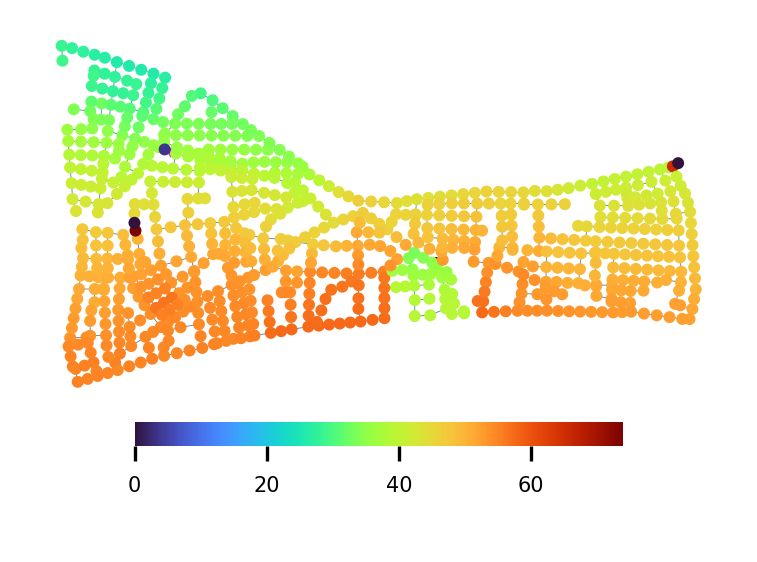

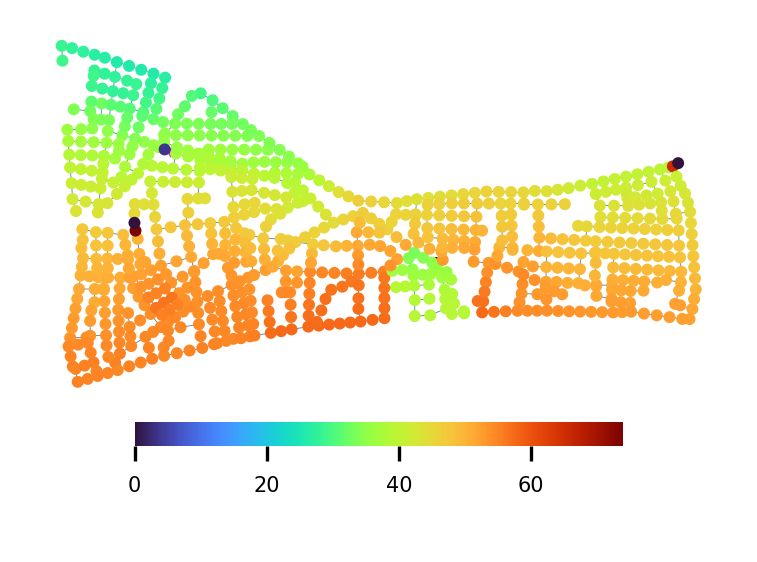

In [1]:
from epyt import epanet
import os
import numpy as np

current_working_directory = os.getcwd()
inp_init_path=current_working_directory+"\\EpyT_init_model.inp"
d = epanet(inp_init_path)
d.openHydraulicAnalysis()
d.initializeHydraulicAnalysis()
tstep, P = 1, []
cnt=0
while True:
   t = d.runHydraulicAnalysis()
   P.append(d.getNodePressure())
   tstep=d.nextHydraulicAnalysisStep()
   print(np.shape(np.asarray(P)))
   if(cnt>=20):
       break
   cnt=cnt+1
d.closeHydraulicAnalysis()
hr = 0
d.plot(node_values = P[hr])

In [7]:
#check https://github.com/SWIL-IITK/EPyT-C
#https://github.com/WaterFutures/EPyT-Flow

In [90]:
from epyt import epanet
import os

current_working_directory = os.getcwd()
inp_init_path=current_working_directory+"\\EpyT_init_model.inp"
d = epanet(inp_init_path)
link_count = d.getLinkCount()
nodes_count= d.getNodeCount()
rules_ID = d.getRules()
control_count=d.getControlRulesCount()
print("Initialization of EpyT model:")
print(" - number of nodes: "+str(nodes_count))
print(" - number of links: "+str(link_count))
print(" - number of rules: "+str(len(rules_ID)))
print(" - number of controls: "+str(control_count))

print("")
nodes_n=d.getNodeNameID()
links_n=[]
for i in range(0,link_count):
    try:
        cur_name=d.getLinkNameID(i)
        links_n.append(cur_name)
    except:
        pass

for m in links_n:
    d.deleteLink(m)
for k in nodes_n:
    d.deleteNode(k)
for v in range(0,control_count):
    d.deleteControls()
d.deleteRules()

print("Cleaned EpyT model:")
print(" - number of nodes: "+str(d.getLinkCount()))
print(" - number of links: "+str(d.getNodeCount()))
print(" - number of rules: "+str(len(d.getRules())))
print(" - number of controls: "+str(d.getControlRulesCount()))
print("")
print("Initialize networkX model...")
print("")


EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File EpyT_init_model.inp loaded successfully.

Initialization of EpyT model:
 - number of nodes: 785
 - number of links: 909
 - number of rules: 0
 - number of controls: 2

Cleaned EpyT model:
 - number of nodes: 0
 - number of links: 0
 - number of rules: 0
 - number of controls: 0

Initialize networkX model...



C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())


In [126]:
def EpyT_makeNet(graph=None, useWaterInputs=True,NodeNames=[],PatternsTimeSerries=[]):
    
    #https://github.com/KIOS-Research/EPyT/blob/main/epyt/examples/EX1_Plot_network_topology.ipynb    
    #https://pypi.org/project/epyt/
    G=graph    
    if(graph==None):
        return None, None, None
    #load model that will be earsed and new model will be introduced on top
    current_working_directory = os.getcwd()
    inp_init_path=current_working_directory+"\\EpyT_init_model.inp"
    d = epanet(inp_init_path)
    link_count = d.getLinkCount()
    nodes_count= d.getNodeCount()
    rules_ID = d.getRules()
    control_count=d.getControlRulesCount()
    print("Initialization of EpyT model:")
    print(" - number of nodes: "+str(nodes_count))
    print(" - number of links: "+str(link_count))
    print(" - number of rules: "+str(len(rules_ID)))
    print(" - number of controls: "+str(control_count))
    
    print("")
    nodes_n=d.getNodeNameID()
    links_n=[]
    for i in range(0,link_count):
        try:
            cur_name=d.getLinkNameID(i)
            links_n.append(cur_name)
        except:
            pass
    
    for m in links_n:
        d.deleteLink(m)
    for k in nodes_n:
        d.deleteNode(k)
    for v in range(0,control_count):
        d.deleteControls()
    d.deleteRules()
    
    print("Cleaned EpyT model:")
    print(" - number of nodes: "+str(d.getLinkCount()))
    print(" - number of links: "+str(d.getNodeCount()))
    print(" - number of rules: "+str(len(d.getRules())))
    print(" - number of controls: "+str(d.getControlRulesCount()))
    print("")
    print("Initialize networkX model...")
    print("")
        
    Used_Nodes_Names=[]
    Pipes_Names=[]
    
    for edge in  G.edges(data=True): #u,outer_d in G.nodes(data=True):      
        
        n1=edge[0]
        n2=edge[1]           
      
        if((n1 in Used_Nodes_Names)==False):                                             
            if(int(G.nodes[n1]["is_junction"])==True):     
                #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html
                x_coord=float(G.nodes[n1]["X"])
                y_coord=float(G.nodes[n1]["Y"])
                coordinates=[x_coord,y_coord]
                junctionElevation = float(G.nodes[n1]["junction_elevation"])
                demand = 50                               
                if (useWaterInputs==True) and (n1 in NodeNames)==True:
                    index=NodeNames.index(n1)
                    patern_name=str('pat_'+n1)
                    time_series=PatternsTimeSerries[index]                    
                    d.addPattern(patern_name,time_series)                         
                    #ptrn=wn.getPatternNameID(patern_name)                   
                    d.addNodeJunction(n1,coordinates,junctionElevation,demand,patern_name)             
                else:                    
                    d.addNodeJunction(n1,coordinates,junctionElevation,demand)   
                                
            if(int(G.nodes[n1]["isStorage"])==True or int(G.nodes[n1]["isOutfall"])==True):                 
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                reservoirCoords = [x_coord, y_coord]
                reservoirIndex = d.addNodeReservoir(n1, reservoirCoords)
                
            Used_Nodes_Names.append(n1)    
           
        # NODE 2     
       
        if((n2 in Used_Nodes_Names)==False):               
            if(int(G.nodes[n2]["is_junction"])==True):         

                #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                coordinates=[x_coord,y_coord]
                junctionElevation = float(G.nodes[n2]["junction_elevation"])
                demand = 50           
                                
                if (useWaterInputs==True) and (n2 in NodeNames)==True:
                    index=NodeNames.index(n2)
                    patern_name=str('pat_'+n2)
                    time_series=PatternsTimeSerries[index]                    
                    d.addPattern(patern_name,time_series)                         
                    d.addNodeJunction(n2,coordinates,junctionElevation,demand,patern_name)              
                else:                    
                    d.addNodeJunction(n2,coordinates,junctionElevation,demand)   
                    
            if(int(G.nodes[n2]["isStorage"])==True or int(G.nodes[n2]["isOutfall"])==True):                
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                reservoirCoords = [x_coord, y_coord]
                reservoirIndex = d.addNodeReservoir(n2, reservoirCoords)   
                
            Used_Nodes_Names.append(n2)       
        #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html        
        pipeID=str(n1)+"_"+str(n2)
        length=float(G.get_edge_data(*edge)["length"])
        diameter=float(G.get_edge_data(*edge)["x_cross_section"])#['weight'])
        roughness=float(G.get_edge_data(*edge)['roughness'])        
        minorLossCoeff=0.0       
        #link_names = wn.getLinkNameID()
        #print(pipeID)
        #if(True):
        #    print(length)
        #    print(diameter)
        #    print(roughness)
        #    print(minorLossCoeff)           
        pipe=d.addLinkPipe(pipeID, n1, n2,length,diameter,roughness,minorLossCoeff)  
        Pipes_Names.append(pipeID)
        #print("pipe added")
        
    print("") 
    print("Transfered from NetworkX EpyT model:")
    print(" - number of nodes: "+str(d.getLinkCount()))
    print(" - number of links: "+str(d.getNodeCount()))
    print(" - number of rules: "+str(len(d.getRules())))
    print(" - number of controls: "+str(d.getControlRulesCount()))
    print("")    
        
    return d, Used_Nodes_Names, Pipes_Names

Map dimensions:
X min: 697526.013
X max: 699814.894
Y min: 248338.455
Y max: 249842.635

Nodes number: 440
440
440
EPANET version 20200 loaded (EPyT version v1.2.0 - Last Update: 01/08/2024).
Input File EpyT_init_model.inp loaded successfully.

Initialization of EpyT model:
 - number of nodes: 785
 - number of links: 909
 - number of rules: 0
 - number of controls: 2

Cleaned EpyT model:
 - number of nodes: 0
 - number of links: 0
 - number of rules: 0
 - number of controls: 0

Initialize networkX model...



C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 204: function call contains undefined link
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 211: function call contains illegal link property value
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\site-packages\epyt\epanet.py:14336: UserWarning: Error 211: function call contains illegal link property value
  warnings.warn(errmssg.value.decode())
C:\Users\shse\AppData\Roaming\Python\Python311\si


Transfered from NetworkX EpyT model:
 - number of nodes: 431
 - number of links: 438
 - number of rules: 0
 - number of controls: 0

-----
Nodes returned to simulator: 438
Links returned to simulator:431


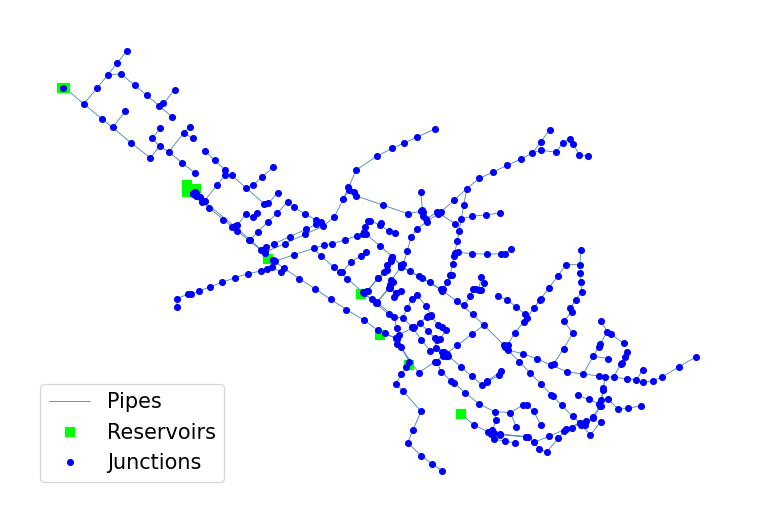

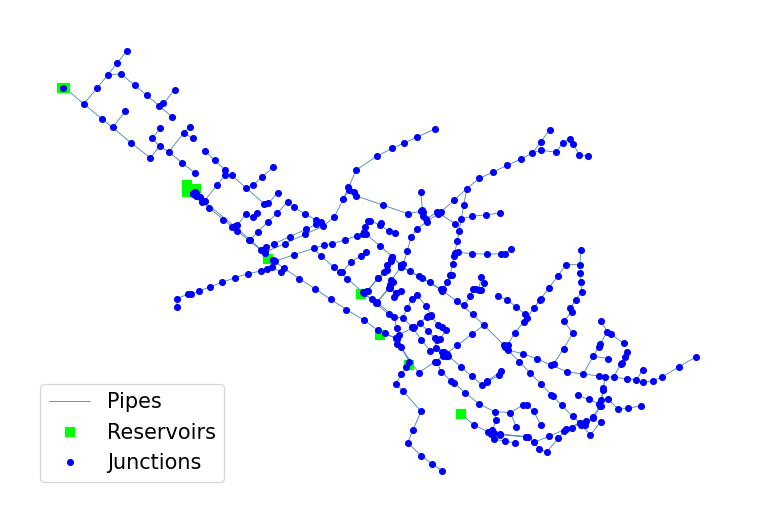

In [130]:
fn="C:\\Users\\shse\\Documents\\ANACONDA\\UTwin_notebooks\\UTWIN_notebooks\\faf_feb16_apr20.inp"
L1,L2,L3,L4,L5,L6,L7,L8,L8_1,L8_2,L8_3,L8_4,L8_5,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25=utr.OpenInp(fn)
Graph,points,pos2=MakeGraph(L1,L2,L3,L4,L5,L6,L7,L8,L8_1,L8_2,L8_3,L8_4,L8_5,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25)

time_series=GenerateSpatialDomain(scenario="Clouds",nodes=L1,
                                                     time_series_length=5000,
                                                     nodes_X=L2,
                                                     nodes_Y=L3,
                                                     spatial_domain_nRows=50,
                                                     spatial_domain_nCol=50,
                                                     rand_gen_type="nlmpy",#"const","nlmpy", "lorenz_attractor", "white_noise","const"
                                                     clouds_max_h=0.76,                                             
                                                     terrain_max_h=0.76,
                                                     clouds_grad_transition=6,
                                                     save_history=False,
                                                     histry_dir="",
                                                     #this are the subdir names
                                                     sub_dir_clouds_history="",
                                                     sub_dir_terrain_hist="",
                                                     sub_dir_time_series_nodes_intake="",
                                                     sub_dir_nodes_params=""
                                                 )


print(len(time_series))
print(len(L1))
#create time series
network,nodes_names,pipe_names=EpyT_makeNet(Graph,NodeNames=L1,useWaterInputs=True,PatternsTimeSerries=time_series)
print("-----")
print("Nodes returned to simulator: "+str(len(nodes_names)))
print("Links returned to simulator:"+str(len(pipe_names)))
network.plot()

In [13]:
def EpyT_makeNet(graph=None, path="",useWaterInputs=True,NodeNames=[],PatternsTimeSerries=[]):
    
    #https://github.com/KIOS-Research/EPyT/blob/main/epyt/examples/EX1_Plot_network_topology.ipynb    
    #https://pypi.org/project/epyt/
    G=graph
    if(path!=""):
        d = epanet(path)
        return d
    if(graph==None):
        return None
        
    wn = epanet()
    Used_Nodes_Names=[]
    Pipes_Names=[]
    
    for edge in  G.edges(data=True): #u,outer_d in G.nodes(data=True):      
        
        n1=edge[0]
        n2=edge[1]   
        
        print("")
        print("Nodes")
        print(n1)
        print(n2)
        print("")
                
        # NODE 1  
        print("")
        print("Node 1")
        
        if((n1 in Used_Nodes_Names)==False):                                             
            if(int(G.nodes[n1]["is_junction"])==True):     
                #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html
                x_coord=float(G.nodes[n1]["X"])
                y_coord=float(G.nodes[n1]["Y"])
                coordinates=[x_coord,y_coord]
                junctionElevation = float(G.nodes[n1]["junction_elevation"])
                demand = 50           
                                
                if (useWaterInputs==True) and (n1 in NodeNames)==True:
                    index=NodeNames.index(n1)
                    patern_name=str('pat_'+n1)
                    time_series=PatternsTimeSerries[index]
                    print(index)
                    wn.addPattern(patern_name,time_series)                         
                    #ptrn=wn.getPatternNameID(patern_name)         
                    print("Added as Junction with time series")
                    wn.addNodeJunction(n1,coordinates,junctionElevation,demand,patern_name)             
                else:
                    print("Added as Junction without time series")
                    wn.addNodeJunction(n1,coordinates,junctionElevation,demand)   
                                
            if(int(G.nodes[n1]["isStorage"])==True or int(G.nodes[n1]["isOutfall"])==True):       
                print("Added as storage ")
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                reservoirCoords = [x_coord, y_coord]
                reservoirIndex = wn.addNodeReservoir(n1, reservoirCoords)
                
            Used_Nodes_Names.append(n1)    
           
        # NODE 2     
        print("")
        print("Node 2")
        
        if((n2 in Used_Nodes_Names)==False):               
            if(int(G.nodes[n2]["is_junction"])==True):         

                #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                coordinates=[x_coord,y_coord]
                junctionElevation = float(G.nodes[n2]["junction_elevation"])
                demand = 50           
                                
                if (useWaterInputs==True) and (n2 in NodeNames)==True:
                    index=NodeNames.index(n2)
                    patern_name=str('pat_'+n2)
                    time_series=PatternsTimeSerries[index]
                    print(index)
                    wn.addPattern(patern_name,time_series)                         
                    #ptrn=wn.getPatternNameID(patern_name) 
                    print("Added as Junction with time series")
                    wn.addNodeJunction(n2,coordinates,junctionElevation,demand,patern_name)              
                else:
                    print("Node added without time series")
                    wn.addNodeJunction(n2,coordinates,junctionElevation,demand)   
                    
            if(int(G.nodes[n2]["isStorage"])==True or int(G.nodes[n2]["isOutfall"])==True):
                print("Added as storage ")
                x_coord=float(G.nodes[n2]["X"])
                y_coord=float(G.nodes[n2]["Y"])
                reservoirCoords = [x_coord, y_coord]
                reservoirIndex = wn.addNodeReservoir(n2, reservoirCoords)   
                
            Used_Nodes_Names.append(n2)     
            

        print("---------------------")
        print("length of nodes used:"+str(len(Used_Nodes_Names)))
        print("---------------------")
        print("")
        print("Ading pipe")
        #https://epanet-python-toolkit-epyt.readthedocs.io/en/latest/api.html        
        pipeID=str(n1)+"-"+str(n2)
        length=float(G.get_edge_data(*edge)["length"])
        diameter=float(G.get_edge_data(*edge)["x_cross_section"])#['weight'])
        roughness=float(G.get_edge_data(*edge)['roughness'])        
        minorLossCoeff=0.0
        print("pipe params:")
        print(length)
        print(diameter)
        print(roughness)
        print(minorLossCoeff)
        #link_names = wn.getLinkNameID()
        wn.addLinkPipe(pipeID, n1, n2,length,diameter,roughness,minorLossCoeff)  
        Pipes_Names.append(pipeID)   
        print("Pipe added with ID:" +str(pipeID))
        
    return wn, Used_Nodes_Names, Pipes_Names

In [44]:
def GenerateSpatialDomain1(scenario="Clouds",nodes=None,
                                             time_series_length=500,
                                             nodes_X=None,
                                             nodes_Y=None,
                                             spatial_domain_nRows=50,
                                             spatial_domain_nCol=50,
                                             spatial_domain_maxMapl=1.5,
                                             rand_gen_type="nlmpy",#"const","nlmpy", "lorenz_attractor", "white_noise","const"
                                             clouds_grad_transition=0,
                                             #save everything related to the simulation
                                             save_history=True,
                                             histry_dir="",
                                             #this are the subdir names
                                             sub_dir_clouds_history="Clouds",
                                             sub_dir_terrain_hist="Terrain",
                                             sub_dir_time_series_nodes_intake="Nodes_Intake",
                                             sub_dir_nodes_params="Nodes_params"
                          ):

    
    
    #variables
    nRow=spatial_domain_nRows
    nCol=spatial_domain_nCol
    h=spatial_domain_maxMapl
    
    #prepare the time series and return variables
    #modes inputs
    rain_node_input=[]
    for i in range(0,len(nodes)):
        rain_node_input.append([])
    #this is terrain
    terrain_map=None
    watershed_map=None
        
    #prepare the coordinates convertions
    min_x_coord= np.min(np.asarray(nodes_X))
    max_x_coord= np.max(np.asarray(nodes_X))
    min_y_coord= np.min(np.asarray(nodes_Y))
    max_y_coord= np.max(np.asarray(nodes_Y))
    ax=(max_x_coord-min_x_coord)/nRow
    bx=min_x_coord
    ay=(max_y_coord-min_y_coord)/nCol
    by=min_y_coord

    #service data
    map_watersheds_accumulation_water=[]

    #check folders
    if(save_history==True):
         if not os.path.exists(histry_dir):
                os.makedirs(histry_dir)
         clouds_data=histry_dir+"\\"+sub_dir_clouds_history
         if not os.path.exists(clouds_data):
                os.makedirs(clouds_data)
         time_series_intake=histry_dir+"\\"+sub_dir_time_series_nodes_intake
         if not os.path.exists(time_series_intake):
             os.makedirs(time_series_intake)
         terrain_data=histry_dir+"\\"+sub_dir_terrain_hist
         if not os.path.exists(terrain_data):
             os.makedirs(terrain_data)
         terrain_water_accum=terrain_data+"\\Water_Accum_Per_WaterSheds"
         if not os.path.exists(terrain_water_accum):
             os.makedirs(terrain_water_accum)
         nodes_params=histry_dir+"\\"+sub_dir_nodes_params
         if not os.path.exists(nodes_params):
             os.makedirs(nodes_params)

    #simple coud, the water falls from cloud directly into the node without watersheds or any other interfaces inbwteen
    #pointwise water introduction
        
    if(scenario=="Clouds"):

        nCol=spatial_domain_nCol
        nRow=spatial_domain_nRows
        CLOUDS_GENERATOR_TYPE=rand_gen_type
        GRADIENT_TRANSITION_SIZE=clouds_grad_transition
        chaos_attr=None
        
        front_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) 
        back_buf,chaos_attr  = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) 
        back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
        
        #start generation of the inputs
        cnt=0
        for i in range(0,time_series_length):
            #first we place the cloud over the spatial domain (e.g. over graph)
            
            if(cnt > nRow + GRADIENT_TRANSITION_SIZE):
                sz_front_buf=np.shape(front_buf)
                front_buf= back_buf[0:sz_front_buf[0]][:]
                back_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=50, nCol=50, h=0.75)
                back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
                cnt=0
            mat_show=StickImages(step=cnt, map_1 = front_buf, map_2 = back_buf)
            cnt=cnt+1
            
            for j in range(0,len(nodes)):
                #original coordinates
                pos_x=nodes_X[j]
                pos_y=nodes_Y[j]    
                #tranlated into spatial domain 
                map_x=int((pos_x-bx)/ax)
                map_y=int((pos_y-by)/ay)

                if(map_x>=nRow):
                    map_x=nRow-1
                if(map_y>=nCol):
                    map_y=nCol-1

                rain_input_value=mat_show[map_x,map_y]
                rain_node_input[j].append(rain_input_value)

            if(save_history==True):
                #save mat_show               
                df = pd.DataFrame(mat_show)
                path_to_save_full=clouds_data+"\\cloud_time_step_"+str(i)+".csv"
                df.to_csv(path_to_save_full, header=False, index=False, sep=' ')

        #save nodes input history
        if(save_history==True):            
            #save nodes intake
            for j in range(0,len(nodes)):
                full_path_file=time_series_intake+"\\"+str(nodes[j])+"_rain_input.csv"
                df = pd.DataFrame(rain_node_input[j])
                df.to_csv(full_path_file, header=False, index=False, sep =' ')
                
        return rain_node_input

    if(scenario == "Clouds+terrain"):
        
        #terrains and its watersheds segmentations
        # watersheds maps can be gererated using watershed algorithm for segmentation
        terrain_map,tmp = Terrain_Gen("nlmpy",nRow=nRow, nCol=nCol, h=0.86)
        l1,l2=WatershedsSeparation(terrain_map,levels=4) #l1 is the small scale, and l2 is the merged version of l1 with levels, given by user
        
        if(save_history==True):
            #save as scv file
            path_terrain=terrain_data+"\\original_terrain.csv"
            df = pd.DataFrame(terrain_map)
            df.to_csv(path_terrain, header=False, index=False, sep =' ')
            #labbeled terrain with watersheds
            path_terrain_watershed=terrain_data+"\\watershed_retailed.csv"
            df = pd.DataFrame(l1)
            df.to_csv(path_terrain_watershed, header=False, index=False, sep =' ')
            #merged watershed
            path_terrain_watershed_leveled=terrain_data+"\\watershed_user_leveled.csv"
            df = pd.DataFrame(l2)
            df.to_csv(path_terrain_watershed_leveled, header=False, index=False, sep =' ')
            
            #save as picture
            path_terrain_figure=terrain_data+"\\terrain_pictures.jpg"
            fig3,(ax1,ax2,ax3) = plt.subplots(1,3)
            #ax1,ax2 = fig3.add_subplot(211)
            ax1.imshow(terrain_map)            
            ax2.imshow(l1, cmap='viridis', interpolation='nearest')            
            ax3.imshow(l2, cmap='viridis', interpolation='nearest')            
            #plt.show(block=False)
            plt.savefig(path_terrain_figure)
            plt.close()
            
        nCol=spatial_domain_nCol
        nRow=spatial_domain_nRows
        CLOUDS_GENERATOR_TYPE=rand_gen_type
        GRADIENT_TRANSITION_SIZE=clouds_grad_transition
        chaos_attr=None
            
        front_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) 
        back_buf,chaos_attr  = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) 
        back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
            
        #start generation of the inputs
        cnt=0
        for sim_time_step in range(0,time_series_length):
                        
            #first we place the cloud over the spatial domain (e.g. over graph)
              
            if(cnt > nRow + GRADIENT_TRANSITION_SIZE):
                sz_front_buf=np.shape(front_buf)
                front_buf= back_buf[0:sz_front_buf[0]][:]
                back_buf,chaos_attr = Terrain_Gen(CLOUDS_GENERATOR_TYPE,nRow=nRow, nCol=nCol, h=h,chaos_obj = chaos_attr) #nlmpy.mpd(nRow=50, nCol=50, h=0.75)
                back_buf=CorrectWithTransitionMap(GRADIENT_TRANSITION_SIZE, map_1 = front_buf, map_2 = back_buf)
                cnt=0
                
            mat_show=StickImages(step=cnt, map_1 = front_buf, map_2 = back_buf)
            cnt=cnt+1
            
            #----------------------------------------------------------------------
            #compute how much rain went inside each segment (e.g. watershed)
            #----------------------------------------------------------------------
            labels=[]
            water_ccum=[]
            #unique_labels=np.unique(l1)
            for i in range(0,nRow):
                for j in range(0,nCol):
                    label=l1[i,j]
                    if (label in labels)==False:
                        labels.append(label)
                        water_ccum.append(mat_show[i,j])
                    else:
                        index = labels.index(label)
                        water_ccum[index]=water_ccum[index] + mat_show[i,j]

            if(save_history==True):
                map_watersheds_accumulation_water=np.zeros((nRow,nCol))
                for i in range(0,nRow):
                   for j in range(0,nCol):  
                       label=l1[i,j]
                       index = labels.index(label)
                       map_watersheds_accumulation_water[i,j] = water_ccum[index]
                #now we save this as CSV file
                df = pd.DataFrame(map_watersheds_accumulation_water)
                path_to_save_full=terrain_water_accum+"\\watershed_accum_map_time_stamp_"+str(sim_time_step)+".csv"
                df.to_csv(path_to_save_full, header=False, index=False, sep=' ')
        
            #----------------------------------------------------------------------
            #-------------------------------------------
            #----------------------------------------------------------------------
                
            for j in range(0,len(nodes)):
                 #original coordinates
                 pos_x=nodes_X[j]
                 pos_y=nodes_Y[j]    
                 #tranlated into spatial domain 
                 map_x=int((pos_x-bx)/ax)
                 map_y=int((pos_y-by)/ay)
    
                 if(map_x>=nRow):
                     map_x=nRow-1
                 if(map_y>=nCol):
                     map_y=nCol-1               
        
                 label=l1[map_x,map_y]
                 index = labels.index(label)
                 rain_input_value=water_ccum[index]
                 rain_node_input[j].append(rain_input_value)
    
            if(save_history==True):                 
                 #save mat_show  which is the current cloud             
                 df = pd.DataFrame(mat_show)
                 path_to_save_full=clouds_data+"\\cloud_time_step_"+str(sim_time_step)+".csv"
                 df.to_csv(path_to_save_full, header=False, index=False, sep=' ')
    
        #save nodes input history
        if(save_history==True):            
             #save nodes intake
             for j in range(0,len(nodes)):
                 full_path_file=time_series_intake+"\\"+str(nodes[j])+"_rain_input.csv"
                 df = pd.DataFrame(rain_node_input[j])
                 df.to_csv(full_path_file, header=False, index=False, sep =' ')
                
        return rain_node_input

In [13]:
import UTwinRoutine as utr
fn="C:\\Users\\shse\\Documents\\ANACONDA\\UTwin_notebooks\\UTWIN_notebooks\\faf_feb16_apr20.inp"
L1,L2,L3,L4,L5,L6,L7,L8,L8_1,L8_2,L8_3,L8_4,L8_5,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25=utr.OpenInp(fn)
print(L8_2)

[0.8, 0.45, 0.3, 0.9, 0.35, 0.35, 0.5, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.35, 0.35, 0.4, 0.4, 0.45, 0.5, 0.45, 0.5, 0.6, 0.6, 0.7, 1.25, 1.25, 0.3, 0.25, 0.25, 0.3, 0.3, 0.25, 0.25, 1.25, 0.25, 0.25, 0.25, 0.25, 0.35, 0.45, 0.45, 0.45, 1.596, 0.4, 0.3, 0.35, 0.35, 0.3, 0.3, 0.3, 0.3, 0.3, 1.25, 0.6, 1.0, 0.3, 0.3, 0.3, 0.4, 0.45, 0.45, 0.5, 0.5, 0.5, 0.5, 0.8, 0.3, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.3, 0.3, 0.35, 0.3, 0.3, 0.3, 0.35, 0.45, 0.4, 0.3, 0.4, 0.3, 0.4, 0.4, 0.45, 0.25, 0.25, 0.3, 0.25, 0.25, 0.25, 0.3, 0.25, 0.25, 0.3, 0.4, 0.4, 0.6, 0.6, 0.6, 0.6, 0.8, 0.8, 0.8, 0.8, 1.0, 0.7, 0.9, 0.9, 0.2, 0.9, 0.6, 0.6, 0.6, 0.6, 0.7, 0.2, 0.3, 0.3, 0.3, 0.2, 0.15, 0.8, 0.8, 0.8, 0.9, 0.2, 0.3, 0.3, 0.35, 0.7, 0.7, 0.9, 0.7, 0.35, 0.15, 0.15, 0.15, 0.15, 1.35, 0.6, 1.0, 0.6, 0.6, 0.6, 0.3, 0.3, 0.3, 0.7, 0.4, 0.6, 0.6, 0.6, 0.6, 1.0, 0.6, 0.6, 1.0, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 1.1, 1.1, 1.1, 1.1, 1.1, 0.7, 0.7, 0.25, 0.25, 0.25, 0.3, 0.3, 0.3, 0.3, 0.3, 0.35, 0.3, 0.7, 0.

In [ ]:
import UTwinRoutine as utr
fn="C:\\Users\\shse\\Documents\\ANACONDA\\UTwin_notebooks\\UTWIN_notebooks\\faf_feb16_apr20.inp"
L1,L2,L3,L4,L5,L6,L7,L8,L8_1,L8_2,L8_3,L8_4,L8_5,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25=utr.OpenInp(fn)
Graph,points,pos2=MakeGraph(L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25)
ppModel,nodes_names,pipes_names=Pandapipes_makeNet(graph=Graph)

In [31]:
import UTwinRoutine as utr
fn="C:\\Users\\shse\\Documents\\ANACONDA\\UTwin_notebooks\\UTWIN_notebooks\\faf_feb16_apr20.inp"
L1,L2,L3,L4,L5,L6,L7,L8,L8_1,L8_2,L8_3,L8_4,L8_5,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25=utr.OpenInp(fn)


Graph,points,pos2=MakeGraph(L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25)

Node_Names=L1
Nodes_coord_X=L2
Nodes_coord_Y=L3
sim_steps=2000
nRow=50
nCol=50
waterIntakeScenario="Clouds+terrain" # "clouds"

Sim_ub_dir_clouds_history="Clouds"
Sim_sub_dir_terrain_hist="Terrain"
Sim_sub_dir_time_series_nodes_intake="Nodes_intake"
Sim_ub_dir_nodes_params="Nodes_params"

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
path_save_all_data="C:\Temp\WEATHER_GENERATOR\\"+dt_string

time_series=GenerateSpatialDomain1(scenario=waterIntakeScenario,
                                                 nodes=Node_Names,
                                                 time_series_length=sim_steps,
                                                 nodes_X=Nodes_coord_X,
                                                 nodes_Y=Nodes_coord_Y,
                                                 spatial_domain_nRows=nRow,
                                                 spatial_domain_nCol=nCol,
                                                 rand_gen_type="nlmpy",#"const","nlmpy", "lorenz_attractor", "white_noise","const"
                                                 clouds_grad_transition=0,
                                                 #if to save all the history
                                                 save_history=True,
                                                 histry_dir=path_save_all_data,
                                                 #this are the subdir names
                                                 sub_dir_clouds_history=Sim_ub_dir_clouds_history,
                                                 sub_dir_terrain_hist=Sim_sub_dir_terrain_hist,
                                                 sub_dir_time_series_nodes_intake=Sim_sub_dir_time_series_nodes_intake,
                                                 sub_dir_nodes_params=Sim_ub_dir_nodes_params
                                             )

self.WnModel,self.WNTR_results,self.WNTR_nodes,self.WNTR_links=WNTR1(graph=self.Graph,
                                                                            sim_dur=sim_steps,
                                                                            duration_type=sim_dur_type,
                                                                            useWaterInputs=True, 
                                                                            NodeNames=Node_Names, 
                                                                            PatternsTimeSerries=time_series
                                                                           )


'\nGraph,points,pos2=MakeGraph(L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25)\n\nNode_Names=L1\nNodes_coord_X=L2\nNodes_coord_Y=L3\nsim_steps=2000\nnRow=50\nnCol=50\nwaterIntakeScenario="Clouds+terrain" # "clouds"\n\nSim_ub_dir_clouds_history="Clouds"\nSim_sub_dir_terrain_hist="Terrain"\nSim_sub_dir_time_series_nodes_intake="Nodes_intake"\nSim_ub_dir_nodes_params="Nodes_params"\n\nnow = datetime.now()\ndt_string = now.strftime("%d_%m_%Y_%H_%M_%S")\npath_save_all_data="C:\\Temp\\WEATHER_GENERATOR\\"+dt_string\n\ntime_series=GenerateSpatialDomain1(scenario=waterIntakeScenario,nodes=Node_Names,\n                                                 time_series_length=sim_steps,\n                                                 nodes_X=Nodes_coord_X,\n                                                 nodes_Y=Nodes_coord_Y,\n                                                 spatial_domain_nRows=nRow,\n                                                 spa

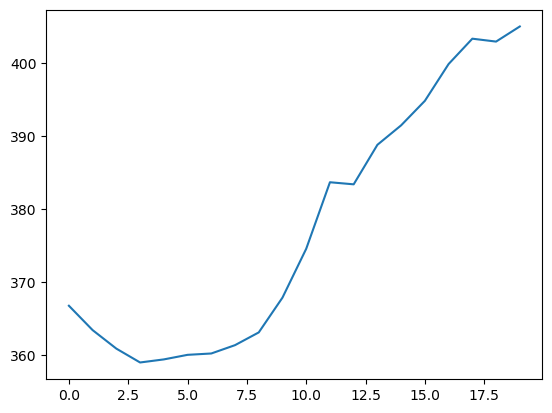

In [31]:
plt.plot(time_series[0])

Map dimensions:
X min: 697526.013
X max: 699814.894
Y min: 248338.455
Y max: 249842.635

Nodes number: 440

***********************
****Simulation WNTR****
***********************
Sim. params:
Sim. start: 11-09-2024-15-19-48
Sim duration: 30000 sec
Sim.end: 11-09-2024 23:39:48

Sim. start day:2024-09-11
Sim. end day:2024-09-11


Simulations are complete
Accessible data:
for nodes - 
dict_keys(['demand', 'head', 'pressure', 'quality'])
for pipes - 
dict_keys(['quality', 'flowrate', 'velocity', 'headloss', 'status', 'setting', 'friction_factor', 'reaction_rate'])

demand
head
pressure
quality


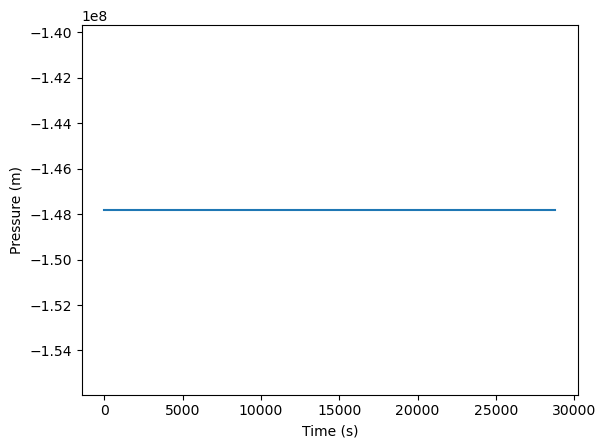

In [14]:
import UTwinRoutine as utr
fn="C:\\Users\\shse\\Documents\\ANACONDA\\UTwin_notebooks\\UTWIN_notebooks\\faf_feb16_apr20.inp"
L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25=utr.OpenInp(fn)
Graph,points,pos2=MakeGraph(L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20,L21,L22,L23,L24,L25)
results,WNTR_nodes,WNTR_links=WNTR(graph=Graph,sim_dur=30000)                              
node_keys = results.node.keys()
link_keys = results.link.keys()

node_keys= list(node_keys)[:]
link_keys= list(link_keys)[:]
for i in node_keys:
    print(i)


pressure = results.node['pressure']
pressure_at_node123 =  results.node['pressure'].loc[:,'123']
fig = plt.figure()
ax = pressure_at_node123.plot()
text = ax.set_xlabel("Time (s)")
text = ax.set_ylabel("Pressure (m)")

In [3]:
import wntr
wn = wntr.network.WaterNetworkModel(fn) 

ENSyntaxError: (Error 201) syntax error (%s), at line 46:
   [FILES] (<string>)

In [ ]:
"""
self.Node_Names=L1
self.Nodes_coord_X=L2
self.Nodes_coord_Y=L3
self.Cond_Names=L4
self.Nodes_in=L5
self.Nodes_out=L6
self.Length=L7
self.Roughness=L8
self.Junc_Names=L9
self.Junc_elevation=L10
self.Junc_max_depth=L11
self.Junc_init_depth=L12
self.Storage_name=L13
self.Storage_elevation=L14
self.Storage_max_depth=L15
self.Pump_name=L16
self.Pump_From_Node=L17
self.Pump_To_Node=L18
self.Pump_Curve=L19
self.Pump_Status=L20
self.Pump_Sartup=L21
self.Pump_Shutoff=L22
self.Outfalls_name=L23
self.Outfalls_elevation=L24
self.Outfalls_type=L25
"""

In [18]:
from pywr.core import Model, Input, Output

# create a model (including an empty network)
model = Model()

# create two nodes: a supply, and a demand
supply = Input(model, name='supply')
demand = Output(model, name='demand')

# create a connection from the supply to the demand
supply.connect(demand)
# set maximum flows
supply.max_flow = 10.0
demand.max_flow = 6.0
# set cost (+ve) or benefit (-ve)
supply.cost = 3.0
demand.cost = -100.0

import datetime
from pywr.core import Timestepper

model.timestepper = Timestepper(
    pandas.to_datetime('2015-01-01'),  # first day
    pandas.to_datetime('2015-12-31'),  # last day
    datetime.timedelta(1)  # interval
)
from pywr.recorders import NumpyArrayNodeRecorder

recorder = NumpyArrayNodeRecorder(model, supply)
# lets get this party started!
model.run()
scenario = 0
timestep = 0
#print(recorder.data[scenario][timestep])  # prints 6.0
print(recorder.data[scenario][:])

[6.]
